In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import lightgbm as lgb
import xgboost as xgb
from sklearn.pipeline import make_pipeline, Pipeline,  FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.preprocessing import LabelEncoder
import catboost as cb
from sklearn.base import clone
import joblib
import optuna
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import os
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import copy
from scipy.special import softmax
from IPython.display import clear_output
from sklearn.linear_model import LogisticRegression

In [2]:
seed = 1126

### EDA

In [3]:
train = pd.read_csv('./baseball_data/train.csv')
test = pd.read_csv('./baseball_data/test.csv')
submission = pd.read_csv('./baseball_data/sample_submission.csv')

In [4]:
train.head()

,uid,pitch_type,release_speed,release_pos_x,release_pos_z,game_type,is_lhp,is_lhb,balls,strikes,...,release_extension,release_pos_y,pitch_number,pitch_name,spin_axis,spray_angle,bat_speed,swing_length,outcome,outcome_code
0,0,FF,93.3,2.01,5.77,R,1,0,0,0,...,6.7,53.80,1,4-Seam Fastball,136,32.304361,76.26113,7.97873,out,0
1,1,SL,86.1,2.00,5.84,R,1,1,1,2,...,6.6,53.87,4,Slider,126,14.241746,61.82557,7.87052,out,0
2,2,SI,92.7,-1.67,6.54,R,0,0,1,1,...,6.9,53.61,3,Sinker,209,-2.398097,69.42584,6.47008,single,1
3,3,FF,92.7,1.97,5.78,R,1,0,2,1,...,6.6,53.85,4,4-Seam Fastball,142,-4.906157,76.19749,8.03785,out,0
4,5,SL,85.7,2.13,5.80,R,1,0,0,2,...,6.7,53.83,3,Slider,313,35.167845,68.84496,6.37508,single,1


In [5]:
test.head()

,uid,pitch_type,release_speed,release_pos_x,release_pos_z,game_type,is_lhp,is_lhb,balls,strikes,...,effective_speed,release_spin_rate,release_extension,release_pos_y,pitch_number,pitch_name,spin_axis,spray_angle,bat_speed,swing_length
0,4,SL,85.4,2.20,5.63,R,1,1,3,2,...,87.0,2298,6.9,53.64,6,Slider,260,-31.164645,73.43104,6.87080
1,11,SL,87.3,2.10,5.82,R,1,0,1,2,...,87.9,2302,6.7,53.82,8,Slider,217,-33.681464,75.32171,7.48533
2,18,FF,94.9,2.05,5.71,R,1,1,3,2,...,96.2,2328,6.9,53.63,8,4-Seam Fastball,144,-17.218933,71.42883,6.91588
3,19,FF,89.2,-2.13,6.40,R,0,1,0,2,...,90.5,2233,6.8,53.71,3,4-Seam Fastball,215,0.671784,63.05006,6.00551
4,21,SL,83.2,-3.27,6.09,R,0,0,0,2,...,83.4,1966,6.2,54.30,3,Slider,182,1.550768,72.77345,8.18495


In [6]:
train.shape, test.shape

((50000, 41), (14220, 39))

In [7]:
train = train.drop(['outcome'], axis = 1)
# test = test.drop(['uid'], axis = 1)

In [8]:
train.duplicated().any().any()

False

In [9]:
cat_features = test.select_dtypes(include='object').columns.tolist()
initial_features = list(test.columns)
for feature in initial_features:
    if feature in cat_features:    
        categories = sorted(set(test[feature].dropna()))
        dtype = pd.CategoricalDtype(categories=categories, ordered=False)
        print(sum(~np.isin(test[feature].unique(),train[feature].unique())))
        print(test[feature].unique()[~np.isin(test[feature].unique(),train[feature].unique())])
        train.loc[~train[feature].isin(categories),feature] = np.nan
        train[feature] = train[feature].astype(dtype)     
        test[feature] = test[feature].astype(dtype)

1
['CS']
0
[]
1
['Slow Curve']


In [10]:
initial_features = list(test.columns)

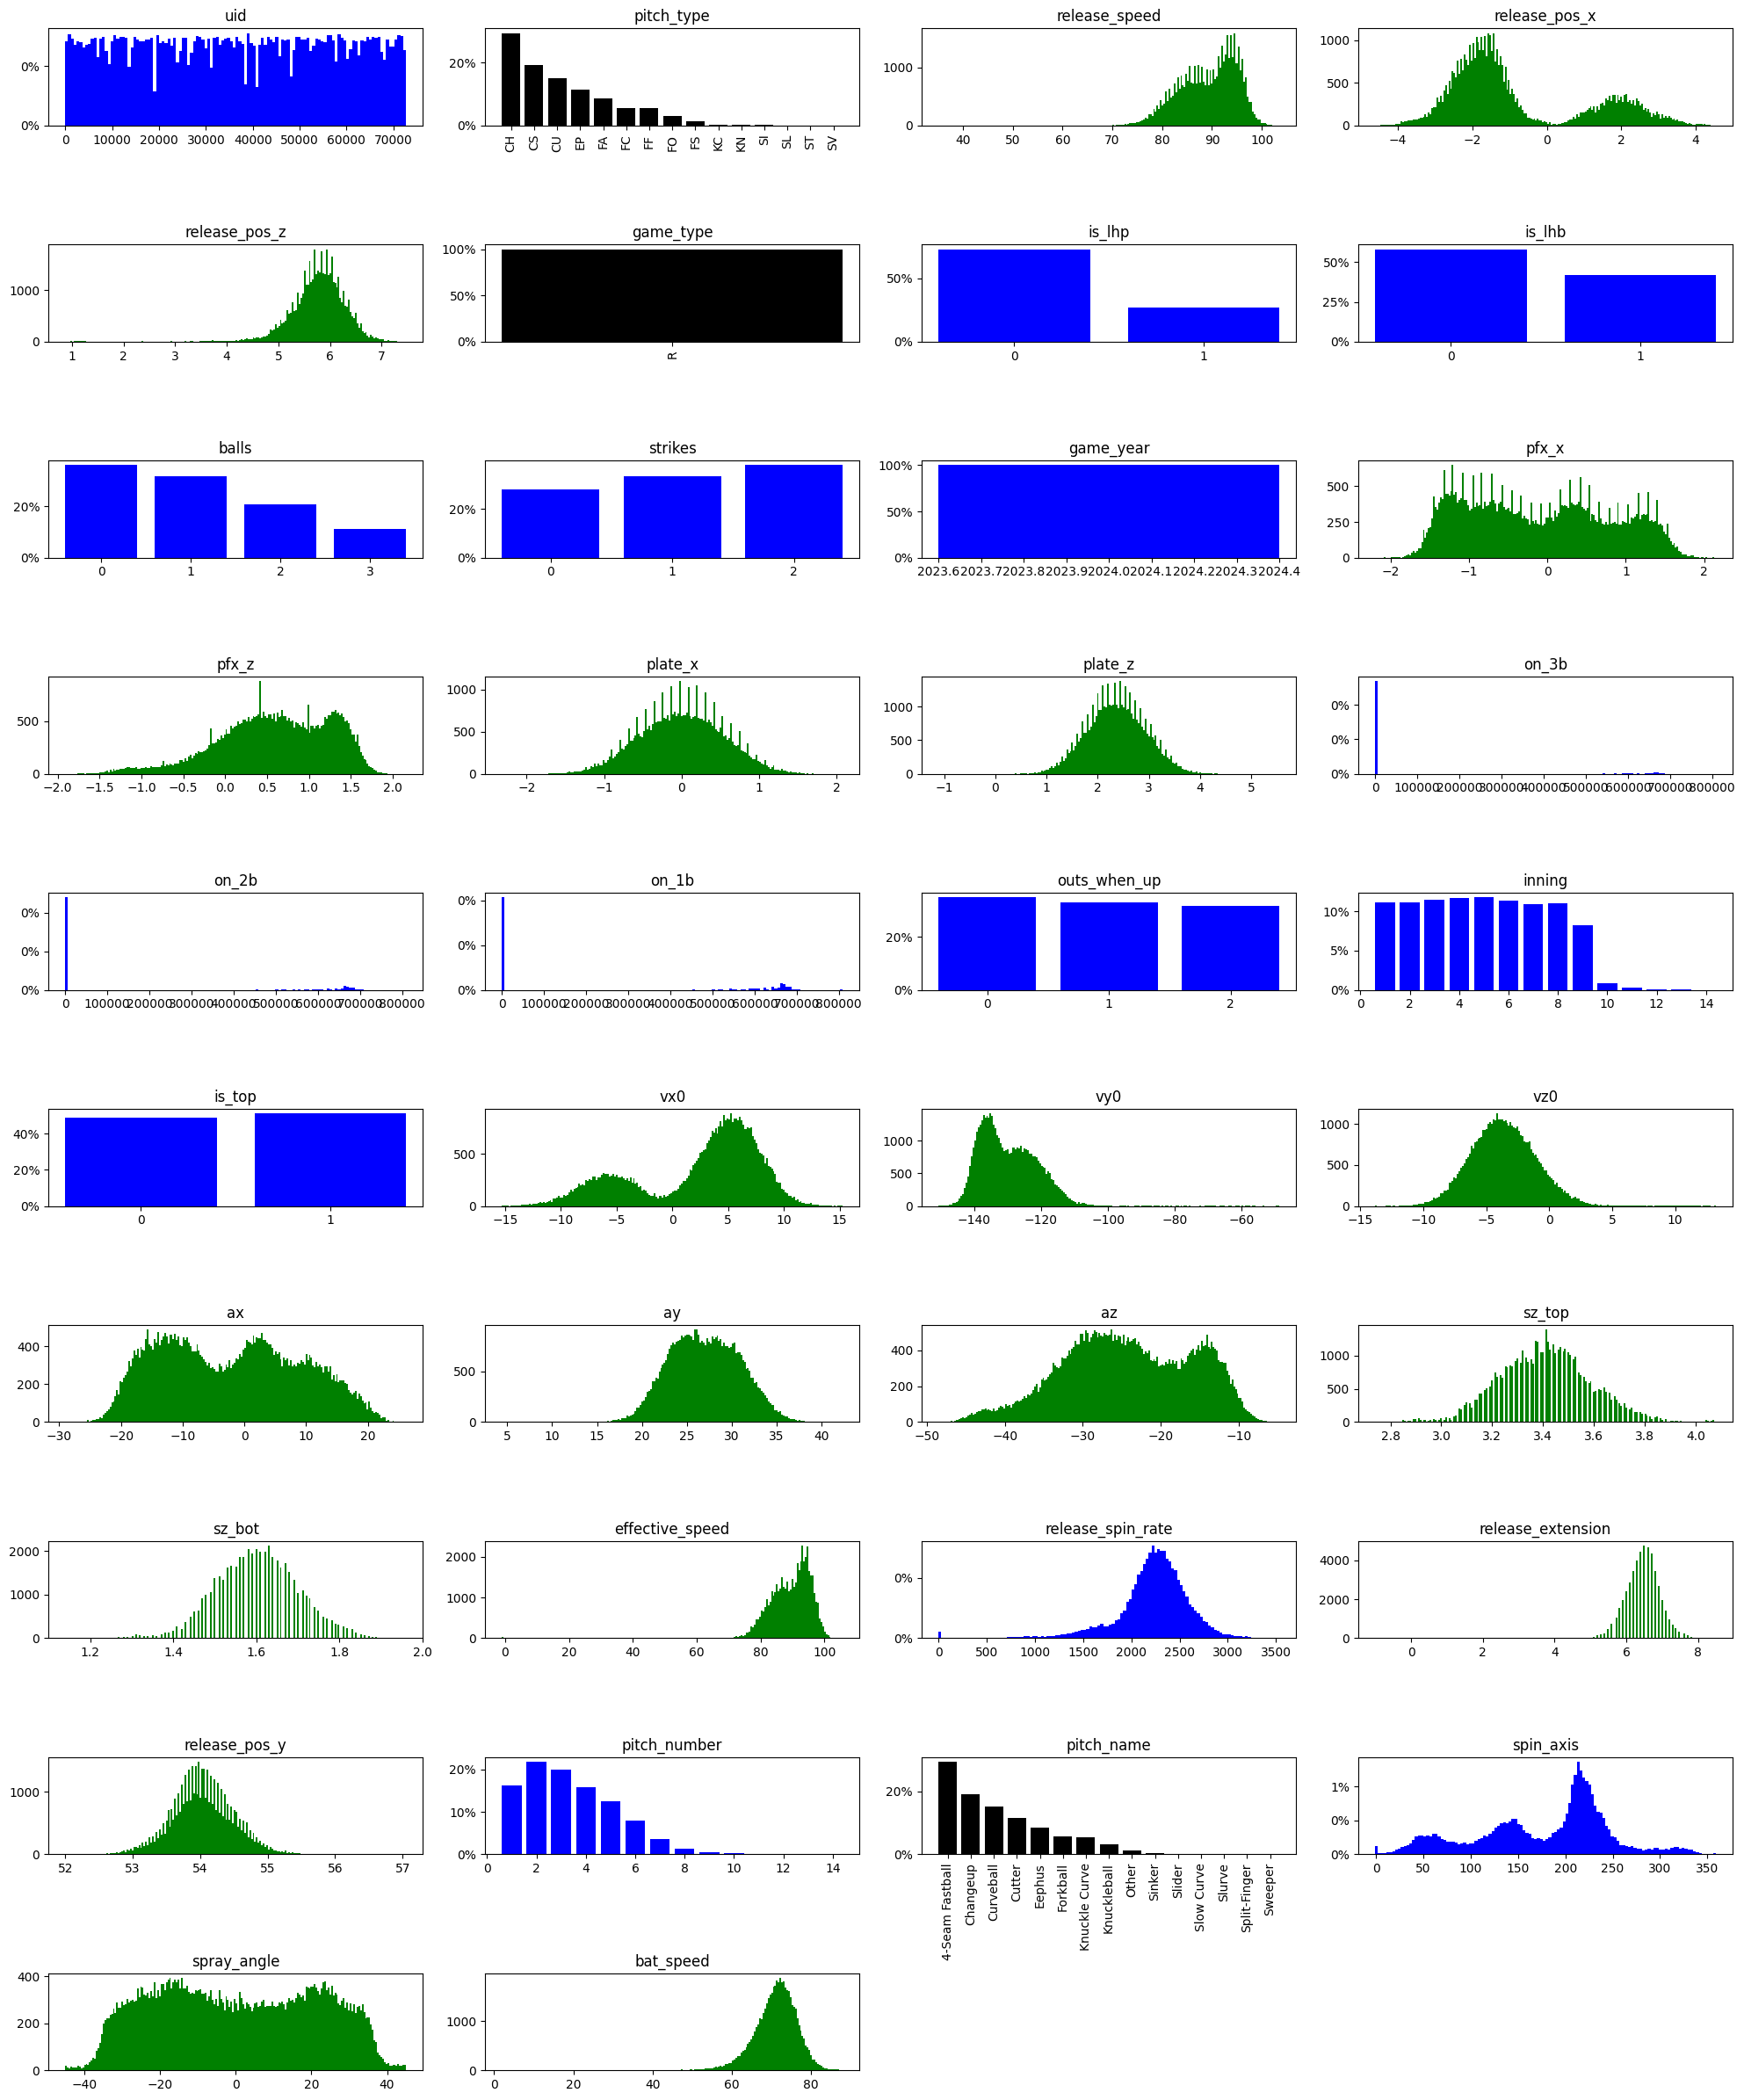

In [11]:
fig, axs = plt.subplots(10,4, figsize=(20,4*6))
for col, ax in zip(initial_features,axs.ravel()):
    if train[col].dtype=='float':
        ax.hist(train[col],color='g',bins=200) 
#         ax.text(0.95,0.95,f'skew: {train[col].skew()}', transform=ax.transAxes,
#                 fontsize=12, verticalalignment='top', horizontalalignment='right')
    elif train[col].dtype=='category':
        vc =train[col].value_counts()/len(train)
        ax.bar(vc.index,vc,color='black')
        ax.yaxis.set_major_formatter('{x:.0%}')
        if len(vc)<=15:
            ax.set_xticks(np.arange(len(train[col].dtype.categories)), train[col].dtype.categories,rotation=90)
        
        else:
            ax.set_xticks([])
    else: 
        vc = train[col].value_counts()/len(train)
        
        ax.yaxis.set_major_formatter('{x:.0%}')
        if len(vc)<=30:
            ax.bar(vc.index, vc, color='blue')            
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        else:
            ax.hist(train[col],color='blue',bins=120,density=True)            
    ax.set_title(f'{col}')
axs.flat[-1].set_visible(False)
axs.flat[-2].set_visible(False)
plt.tight_layout()    
#plt.subplots_adjust(hspace=0.5)
plt.show()

In [12]:
drop_cols = ['game_year','game_type']
target = 'outcome_code'

In [13]:
train = train.drop(drop_cols, axis = 1)
train = train.drop(['uid'], axis = 1)
test = test.drop(drop_cols, axis = 1)
cat_features = test.select_dtypes(include = 'category').columns.tolist()
initial_features = train.columns[:-1].tolist()

In [14]:
print(len(initial_features))

36


Text(0.5, 1.0, 'Targets')

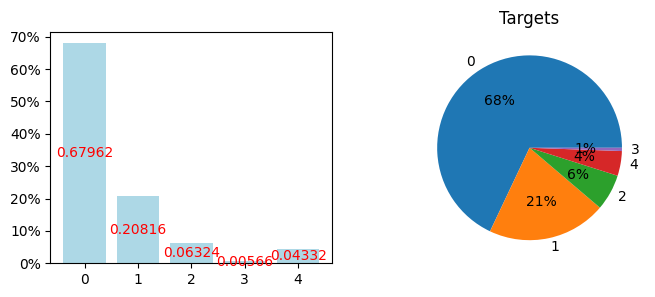

In [15]:
_, axs = plt.subplots(1, 2, figsize=(8, 3))
ax = axs.ravel()
vc = train[target].value_counts()/len(train)
ax[0].bar(vc.index, vc, color='lightblue')
ax[0].bar_label(ax[0].containers[0], label_type='center', color='red')
ax[0].yaxis.set_major_formatter('{x:.0%}')
vc = train[target].value_counts()
ax[1].pie(vc,labels=vc.index, autopct='%.0f%%')
plt.title('Targets')

### Original Modeling

In [16]:
X = train.drop([target], axis = 1)
y = train[target]

In [17]:
X.columns

Index(['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z',
       'is_lhp', 'is_lhb', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x',
       'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning',
       'is_top', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'release_pos_y', 'pitch_number', 'pitch_name', 'spin_axis',
       'spray_angle', 'bat_speed', 'swing_length'],
      dtype='object')

In [18]:
X.select_dtypes(include='category').columns.tolist()

['pitch_type', 'pitch_name']

In [19]:
for feature in cat_features:
    # For training data
    if X[feature].dtype.name == 'category':
        # Add 'Unknown' to categories if it's not already there
        if 'Unknown' not in X[feature].cat.categories:
            X[feature] = X[feature].cat.add_categories('Unknown')
        X[feature] = X[feature].fillna('Unknown')
    else:
        X[feature] = X[feature].fillna('Unknown').astype('category')
    
    # For test data
    if test[feature].dtype.name == 'category':
        # Ensure all categories from training data are in test data
        test[feature] = test[feature].cat.add_categories(X[feature].cat.categories.difference(test[feature].cat.categories))
        if 'Unknown' not in test[feature].cat.categories:
            test[feature] = test[feature].cat.add_categories('Unknown')
        test[feature] = test[feature].fillna('Unknown')
    else:
        test[feature] = test[feature].fillna('Unknown').astype('category')
    
    # Ensure both train and test have the same categories
    all_categories = X[feature].cat.categories.union(test[feature].cat.categories)
    X[feature] = X[feature].cat.set_categories(all_categories)
    test[feature] = test[feature].cat.set_categories(all_categories)

In [20]:
def custom_cross_validate_v1(model, X, y, cv, model_path, fit_params = {}):

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        fold_model = clone(model)

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        fit_params['eval_set'] = [(X_val, y_val)]
        
        # Fit the model with categorical features
        fold_model.fit(X_train, y_train, **fit_params)
        
        # Predict probabilities for the validation set
        y_preds = fold_model.predict(X_val)
        y_preds_prob = fold_model.predict_proba(X_val)
        
        # Calculate and print AUC for the current fold
        auc_score = roc_auc_score(y_val, y_preds_prob, multi_class = 'ovr')
        print(f"Fold {fold + 1} - AUC: {auc_score:.4f}\n")
        print(classification_report(y_val, y_preds))
        print('----------------------------------------------\n')

        joblib.dump(fold_model, model_path + f'fold{fold + 1}.pkl')

In [21]:
cat_features

['pitch_type', 'pitch_name']

In [22]:
X.isna().any().any()

False

##### CatBoost Modeling

In [27]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
model_path = './saved_models/catboost/'
cb_model = cb.CatBoostClassifier(iterations = 1000, learning_rate = 0.05, random_state = seed, eval_metric = 'AUC', verbose = False, cat_features = cat_features, task_type = "GPU")
custom_cross_validate_v1(cb_model, X, y, kf, model_path)

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


Fold 1 - AUC: 0.7339

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6797
           1       0.35      0.01      0.02      2081
           2       0.45      0.09      0.15       633
           3       0.00      0.00      0.00        56
           4       0.30      0.01      0.01       433

    accuracy                           0.68     10000
   macro avg       0.36      0.22      0.20     10000
weighted avg       0.58      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 2 - AUC: 0.7510

              precision    recall  f1-score   support

           0       0.68      1.00      0.81      6796
           1       0.50      0.00      0.00      2082
           2       0.50      0.09      0.15       632
           3       0.00      0.00      0.00        56
           4       0.33      0.00      0.00       434

    accuracy                           0.68     10000
   macro avg       0.40      0.22      0.19     10000
weighted avg       0.62      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 3 - AUC: 0.7354

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.56      0.01      0.01      2082
           2       0.43      0.08      0.13       632
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.33      0.22      0.19     10000
weighted avg       0.61      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 4 - AUC: 0.7265

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.50      0.00      0.00      2082
           2       0.45      0.07      0.12       632
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.33      0.21      0.19     10000
weighted avg       0.60      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 5 - AUC: 0.7413

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.37      0.00      0.01      2081
           2       0.45      0.06      0.11       633
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.30      0.21      0.19     10000
weighted avg       0.57      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [28]:
selected_fold = 2
final_model_path = model_path + f'fold{selected_fold}.pkl'
final_model = joblib.load(final_model_path)
final_preds = final_model.predict_proba(test.drop(['uid'], axis = 1))

In [29]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [30]:
submission.to_csv('./submissions/first_attempt.csv', index = False)

Submission results<br>
Public Score: 0.72142<br>
Private Score: 0.73799

Try to use voting method

In [30]:
model_path = './saved_models/catboost/'
total_fold_preds = []

for i in range(1, 6):
    fold_path = model_path + f'fold{i}.pkl'
    fold_model = joblib.load(fold_path)
    fold_preds = fold_model.predict_proba(test.drop(['uid'], axis = 1))
    total_fold_preds.append(fold_preds)

total_fold_preds = np.array(total_fold_preds)

In [36]:
total_fold_preds.shape

(5, 14220, 5)

In [40]:
final_preds = np.mean(total_fold_preds, axis = 0)

In [41]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [43]:
submission.to_csv('./submissions/eighth_attempt.csv', index = False)

Submission results<br>
Public Score: 0.72635<br>
Private Score: 0.74334

##### LightGBM Modeling

In [45]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
model_path = './saved_models/lightgbm/'
lgb_model = lgb.LGBMClassifier(verbosity = -1, random_state = seed, objective = 'multiclass', num_class = 5, n_estimators = 1000, learning_rate = 0.02, cat_features = cat_features, device = "gpu")
custom_cross_validate_v1(lgb_model, X, y, kf, model_path)

Fold 1 - AUC: 0.7155

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6797
           1       0.32      0.01      0.02      2081
           2       0.42      0.07      0.11       633
           3       0.00      0.00      0.00        56
           4       0.22      0.00      0.01       433

    accuracy                           0.68     10000
   macro avg       0.33      0.21      0.19     10000
weighted avg       0.57      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 2 - AUC: 0.7187

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.40      0.01      0.02      2082
           2       0.47      0.08      0.13       632
           3       0.00      0.00      0.00        56
           4       0.41      0.02      0.03       434

    accuracy                           0.68     10000
   macro avg       0.39      0.22      0.20     10000
weighted avg       0.60      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 3 - AUC: 0.7037

              precision    recall  f1-score   support

           0       0.69      0.99      0.81      6796
           1       0.41      0.01      0.03      2082
           2       0.43      0.08      0.14       632
           3       0.00      0.00      0.00        57
           4       0.42      0.02      0.04       433

    accuracy                           0.68     10000
   macro avg       0.39      0.22      0.20     10000
weighted avg       0.60      0.68      0.57     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 4 - AUC: 0.6978

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.36      0.01      0.02      2082
           2       0.32      0.06      0.09       632
           3       0.00      0.00      0.00        57
           4       0.20      0.00      0.01       433

    accuracy                           0.68     10000
   macro avg       0.31      0.21      0.19     10000
weighted avg       0.57      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 5 - AUC: 0.7099

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.40      0.01      0.02      2081
           2       0.49      0.07      0.12       633
           3       0.00      0.00      0.00        57
           4       0.57      0.02      0.04       433

    accuracy                           0.68     10000
   macro avg       0.43      0.22      0.20     10000
weighted avg       0.60      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [46]:
selected_fold = 2
final_model_path = model_path + f'fold{selected_fold}.pkl'
final_model = joblib.load(final_model_path)
final_preds = final_model.predict_proba(test.drop(['uid'], axis = 1))

In [47]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [48]:
submission.to_csv('./submissions/second_attempt.csv', index = False)

Submission results<br>
Public Score: 0.71958<br>
Private Score: 0.70918

Try to use voting method

In [49]:
model_path = './saved_models/lightgbm/'
total_fold_preds = []

for i in range(1, 6):
    fold_path = model_path + f'fold{i}.pkl'
    fold_model = joblib.load(fold_path)
    fold_preds = fold_model.predict_proba(test.drop(['uid'], axis = 1))
    total_fold_preds.append(fold_preds)

total_fold_preds = np.array(total_fold_preds)

In [50]:
final_preds = np.mean(total_fold_preds, axis = 0)

In [51]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [52]:
submission.to_csv('./submissions/ninth_attempt.csv', index = False)

Submission results<br>
Public Score: 0.69969<br>
Private Score: 0.72575

##### DNN Modeling

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024
epochs = 50
lr = 1e-3

In [24]:
X_torch = X.copy()
test_torch = test.copy()
for c in cat_features:
    lbl_enc = LabelEncoder()
    tmp = pd.concat([X, test.drop(['uid'], axis = 1)])
    lbl_enc.fit(tmp[c])

    X_torch[c] = lbl_enc.transform(X[c])
    test_torch[c] = lbl_enc.transform(test[c])

In [25]:
cat_dim = [int(len(X[col].cat.categories)) for col in cat_features]
cat_dim = [[x, min(50, (x + 1) // 2)] for x in cat_dim]

In [26]:
cat_dim

[[16, 8], [16, 8]]

In [27]:
cont_features = X.columns.to_list()

for c in cat_features:
    cont_features.remove(c)

In [28]:
def seed_everything(TORCH_SEED):
	random.seed(TORCH_SEED)
	os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
	np.random.seed(TORCH_SEED)
	torch.manual_seed(TORCH_SEED)
	torch.cuda.manual_seed_all(TORCH_SEED)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [29]:
seed_everything(seed)

In [30]:
class ClassificationDataset(Dataset):
    def __init__(self, features, labels = None, cat_cols_idx = None, cont_cols_idx = None, is_train = True):
        self.X = features
        self.y = labels
        self.is_train = is_train
        self.cat_cols_idx = cat_cols_idx
        self.cont_cols_idx = cont_cols_idx
    
    def __getitem__(self, idx):
        data_cat = []
        data_cont = []
        
        result = None
        
        if self.cat_cols_idx:
            data_cat = torch.tensor(self.X.loc[idx, self.cat_cols_idx].values, dtype = torch.int64)
            
        if self.cont_cols_idx:
            data_cont = torch.tensor(self.X.loc[idx, self.cont_cols_idx].values, dtype = torch.float32)
                
        data = [data_cat, data_cont]
                
        if self.is_train:
            result = {'data': data,
                      'target': torch.tensor(self.y[idx], dtype = torch.int64)}
        else:
            result = {'data': data}
            
        return result      
    
    def __len__(self):
        return(self.X.shape[0])

In [31]:
class ClassificationEmbdNN(torch.nn.Module):
    
    def __init__(self, emb_dims, no_of_cont = None):
        super(ClassificationEmbdNN, self).__init__()
        
        self.emb_layers = torch.nn.ModuleList([torch.nn.Embedding(x, y)
                                               for x, y in emb_dims])
        
        no_of_embs = sum([y for x, y in emb_dims])
        self.no_of_embs = no_of_embs
        self.emb_dropout = torch.nn.Dropout(0.2)
        
        self.no_of_cont = 0
        if no_of_cont:
            self.no_of_cont = no_of_cont
            self.bn_cont = torch.nn.BatchNorm1d(no_of_cont)
        
        self.fc1 = torch.nn.Linear(in_features = self.no_of_embs + self.no_of_cont, out_features = 64)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(in_features = 64, out_features = 32)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.bn2 = torch.nn.BatchNorm1d(32)
        self.act2 = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(in_features = 32, out_features = 5)
        
    def forward(self, x_cat, x_cont=None):
        if self.no_of_embs != 0:
            x = [emb_layer(x_cat[:, i]) for i, emb_layer in enumerate(self.emb_layers)]
        
            x = torch.cat(x, 1)
            x = self.emb_dropout(x)
            
        if self.no_of_cont != 0:
            x_cont = self.bn_cont(x_cont)
            
            if self.no_of_embs != 0:
                x = torch.cat([x, x_cont], 1)
            else:
                x = x_cont
        
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        x = self.act2(x)
        
        x = self.fc3(x)
        
        return x

In [56]:
# def build_model(cat_dim, no_of_cont):
#     DNN_model = ClassificationEmbdNN(cat_dim, no_of_cont = no_of_cont)

#     return DNN_model

In [32]:
def train_network(model, train_loader, valid_loader, loss_func, optimizer, n_epochs=20, model_path = './saved_models/DNN/model.pt'):

    model.to(device)
    
    # train_losses = list()
    # valid_losses = list()
    
    valid_loss_min = np.inf
    
    for epoch in range(n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0.0
        valid_acc = 0.0
        
        model.train()
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            
            output = model(batch['data'][0].to(device),
                           batch['data'][1].to(device))
            
            loss = loss_func(output, batch['target'].to(device))
            
            loss.backward()
            optimizer.step()
            
            train_preds = torch.argmax(output, dim = 1)
            train_acc += np.sum(batch['target'].cpu().numpy() == train_preds.detach().cpu().numpy())

            train_loss += loss.item() * batch['data'][0].size(0)
    

        model.eval()
        for batch in tqdm(valid_loader):
            output = model(batch['data'][0].to(device),
                           batch['data'][1].to(device))
            
            
            loss = loss_func(output, batch['target'].to(device))
            
            val_preds = torch.argmax(output, dim = 1)
            valid_acc += np.sum(batch['target'].cpu().numpy() == val_preds.cpu().numpy())

            valid_loss += loss.item() * batch['data'][0].size(0)
           
        
        train_loss = np.sqrt(train_loss / len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss / len(valid_loader.sampler.indices))

        train_acc = train_acc / len(train_loader.sampler.indices)
        valid_acc = valid_acc / len(valid_loader.sampler.indices)
        
        # train_losses.append(train_loss)
        # valid_losses.append(valid_loss)

        print('Epoch: {}. Training loss: {:.6f}. Validation loss: {:.6f}'
              .format(epoch + 1, train_loss, valid_loss))
        print('Training ACC: {:.6f}. Validation ACC: {:.6f}'
              .format(train_acc, valid_acc))
        
        if valid_loss < valid_loss_min:  # let's save the best weights to use them in prediction
            print('Validation Loss decreased ({:.6f} --> {:.6f}). Saving model...'
                  .format(valid_loss_min, valid_loss))
            
            torch.save(model.state_dict(), model_path)
            valid_loss_min = valid_loss
    
        #Load best model in this fold
        best_model = copy.deepcopy(model)
        best_model.load_state_dict(torch.load(model_path))
            
    return best_model

In [33]:
def custom_cross_validate_v1_torch(model, trainset, cv, model_path):

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        fold_model = copy.deepcopy(model)
        total_targets = np.array([])
        total_outputs = np.array([])

        val_sampler = SubsetRandomSampler(val_idx)
        train_sampler = SubsetRandomSampler(train_idx)

        train_loader = torch.utils.data.DataLoader(
                      trainset, batch_size = batch_size, pin_memory = True, sampler = train_sampler, drop_last = True)
        val_loader = torch.utils.data.DataLoader(
                      trainset, batch_size = batch_size, pin_memory = True, sampler = val_sampler, drop_last = False)
        
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(fold_model.parameters(), lr = lr)
        
        # Fit the model with categorical features
        fold_model = train_network(fold_model, train_loader, val_loader, loss_function, optimizer, n_epochs = epochs, model_path = model_path + f'fold{fold + 1}.pt')
        
        # Predict probabilities for the validation set
        fold_model.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader):
                output = fold_model(batch['data'][0].to(device), batch['data'][1].to(device))
                total_targets = np.append(total_targets, batch['target'].numpy())
                total_outputs = np.append(total_outputs, output.data.cpu().numpy().flatten())
        
            total_outputs = total_outputs.reshape(-1, 5)
            total_outputs = softmax(total_outputs, axis = 1)
            total_preds = total_outputs.argmax(axis = 1)

        # Calculate and print AUC for the current fold
        auc_score = roc_auc_score(total_targets, total_outputs, multi_class = 'ovr')
        print(f"Fold {fold + 1} - AUC: {auc_score:.4f}\n")
        print(classification_report(total_targets, total_preds))
        print('----------------------------------------------\n')

        if fold % 2 == 1:
            clear_output()

In [34]:
train_dataset = ClassificationDataset(X_torch, y.values, cat_features, cont_features, is_train = True)
test_dataset = ClassificationDataset(test_torch.drop(['uid'], axis = 1), labels = None, cat_cols_idx = cat_features, cont_cols_idx = cont_features, is_train = False)

In [35]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
model_path = './saved_models/DNN/'
DNN_model = ClassificationEmbdNN(cat_dim, no_of_cont = len(cont_features))
custom_cross_validate_v1_torch(DNN_model, train_dataset, kf, model_path)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1. Training loss: 1.298051. Validation loss: 1.217002
Training ACC: 0.203325. Validation ACC: 0.325000
Validation Loss decreased (inf --> 1.217002). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2. Training loss: 1.114018. Validation loss: 1.095729
Training ACC: 0.588700. Validation ACC: 0.671000
Validation Loss decreased (1.217002 --> 1.095729). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3. Training loss: 1.021232. Validation loss: 1.030217
Training ACC: 0.674675. Validation ACC: 0.679600
Validation Loss decreased (1.095729 --> 1.030217). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4. Training loss: 0.984930. Validation loss: 0.997873
Training ACC: 0.678350. Validation ACC: 0.679600
Validation Loss decreased (1.030217 --> 0.997873). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5. Training loss: 0.970795. Validation loss: 0.985841
Training ACC: 0.678200. Validation ACC: 0.679600
Validation Loss decreased (0.997873 --> 0.985841). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6. Training loss: 0.965124. Validation loss: 0.974340
Training ACC: 0.678050. Validation ACC: 0.679400
Validation Loss decreased (0.985841 --> 0.974340). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7. Training loss: 0.960352. Validation loss: 0.968954
Training ACC: 0.678275. Validation ACC: 0.679600
Validation Loss decreased (0.974340 --> 0.968954). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8. Training loss: 0.956475. Validation loss: 0.964221
Training ACC: 0.678325. Validation ACC: 0.679700
Validation Loss decreased (0.968954 --> 0.964221). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9. Training loss: 0.953804. Validation loss: 0.958587
Training ACC: 0.678525. Validation ACC: 0.679600
Validation Loss decreased (0.964221 --> 0.958587). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10. Training loss: 0.950436. Validation loss: 0.956582
Training ACC: 0.678225. Validation ACC: 0.679600
Validation Loss decreased (0.958587 --> 0.956582). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11. Training loss: 0.948193. Validation loss: 0.954125
Training ACC: 0.678475. Validation ACC: 0.679600
Validation Loss decreased (0.956582 --> 0.954125). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12. Training loss: 0.945708. Validation loss: 0.950084
Training ACC: 0.678350. Validation ACC: 0.679600
Validation Loss decreased (0.954125 --> 0.950084). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13. Training loss: 0.943996. Validation loss: 0.947286
Training ACC: 0.678575. Validation ACC: 0.679700
Validation Loss decreased (0.950084 --> 0.947286). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14. Training loss: 0.942694. Validation loss: 0.946126
Training ACC: 0.678500. Validation ACC: 0.679700
Validation Loss decreased (0.947286 --> 0.946126). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15. Training loss: 0.940363. Validation loss: 0.943794
Training ACC: 0.678375. Validation ACC: 0.679700
Validation Loss decreased (0.946126 --> 0.943794). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16. Training loss: 0.939355. Validation loss: 0.941006
Training ACC: 0.678425. Validation ACC: 0.679700
Validation Loss decreased (0.943794 --> 0.941006). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17. Training loss: 0.937793. Validation loss: 0.939051
Training ACC: 0.678375. Validation ACC: 0.679700
Validation Loss decreased (0.941006 --> 0.939051). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18. Training loss: 0.937290. Validation loss: 0.937672
Training ACC: 0.678400. Validation ACC: 0.679700
Validation Loss decreased (0.939051 --> 0.937672). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19. Training loss: 0.934833. Validation loss: 0.935464
Training ACC: 0.678475. Validation ACC: 0.679700
Validation Loss decreased (0.937672 --> 0.935464). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20. Training loss: 0.933776. Validation loss: 0.934389
Training ACC: 0.678325. Validation ACC: 0.679700
Validation Loss decreased (0.935464 --> 0.934389). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21. Training loss: 0.932659. Validation loss: 0.932327
Training ACC: 0.678625. Validation ACC: 0.679700
Validation Loss decreased (0.934389 --> 0.932327). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22. Training loss: 0.932178. Validation loss: 0.930545
Training ACC: 0.678500. Validation ACC: 0.679600
Validation Loss decreased (0.932327 --> 0.930545). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23. Training loss: 0.930208. Validation loss: 0.929787
Training ACC: 0.678450. Validation ACC: 0.679600
Validation Loss decreased (0.930545 --> 0.929787). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24. Training loss: 0.929063. Validation loss: 0.929511
Training ACC: 0.678600. Validation ACC: 0.679600
Validation Loss decreased (0.929787 --> 0.929511). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25. Training loss: 0.929159. Validation loss: 0.927938
Training ACC: 0.678800. Validation ACC: 0.679500
Validation Loss decreased (0.929511 --> 0.927938). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26. Training loss: 0.928404. Validation loss: 0.928032
Training ACC: 0.678450. Validation ACC: 0.679600


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27. Training loss: 0.928039. Validation loss: 0.926383
Training ACC: 0.678425. Validation ACC: 0.679600
Validation Loss decreased (0.927938 --> 0.926383). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28. Training loss: 0.926667. Validation loss: 0.925601
Training ACC: 0.678425. Validation ACC: 0.679700
Validation Loss decreased (0.926383 --> 0.925601). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29. Training loss: 0.927007. Validation loss: 0.925404
Training ACC: 0.678500. Validation ACC: 0.679800
Validation Loss decreased (0.925601 --> 0.925404). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30. Training loss: 0.926364. Validation loss: 0.924241
Training ACC: 0.678550. Validation ACC: 0.679800
Validation Loss decreased (0.925404 --> 0.924241). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 31. Training loss: 0.925352. Validation loss: 0.923039
Training ACC: 0.678550. Validation ACC: 0.679800
Validation Loss decreased (0.924241 --> 0.923039). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 32. Training loss: 0.925107. Validation loss: 0.923417
Training ACC: 0.678350. Validation ACC: 0.680000


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 33. Training loss: 0.923635. Validation loss: 0.922102
Training ACC: 0.678600. Validation ACC: 0.680000
Validation Loss decreased (0.923039 --> 0.922102). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 34. Training loss: 0.923528. Validation loss: 0.921723
Training ACC: 0.678325. Validation ACC: 0.679800
Validation Loss decreased (0.922102 --> 0.921723). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 35. Training loss: 0.922221. Validation loss: 0.920695
Training ACC: 0.678475. Validation ACC: 0.679800
Validation Loss decreased (0.921723 --> 0.920695). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 36. Training loss: 0.922612. Validation loss: 0.920481
Training ACC: 0.678700. Validation ACC: 0.679300
Validation Loss decreased (0.920695 --> 0.920481). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 37. Training loss: 0.921494. Validation loss: 0.919868
Training ACC: 0.678650. Validation ACC: 0.679700
Validation Loss decreased (0.920481 --> 0.919868). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 38. Training loss: 0.921997. Validation loss: 0.919407
Training ACC: 0.678300. Validation ACC: 0.679700
Validation Loss decreased (0.919868 --> 0.919407). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 39. Training loss: 0.920714. Validation loss: 0.919150
Training ACC: 0.678525. Validation ACC: 0.679500
Validation Loss decreased (0.919407 --> 0.919150). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 40. Training loss: 0.920719. Validation loss: 0.918600
Training ACC: 0.678325. Validation ACC: 0.679100
Validation Loss decreased (0.919150 --> 0.918600). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 41. Training loss: 0.920839. Validation loss: 0.918406
Training ACC: 0.678000. Validation ACC: 0.679600
Validation Loss decreased (0.918600 --> 0.918406). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 42. Training loss: 0.920000. Validation loss: 0.918311
Training ACC: 0.678500. Validation ACC: 0.679100
Validation Loss decreased (0.918406 --> 0.918311). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 43. Training loss: 0.920447. Validation loss: 0.918502
Training ACC: 0.678175. Validation ACC: 0.679400


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 44. Training loss: 0.918568. Validation loss: 0.917805
Training ACC: 0.678775. Validation ACC: 0.679700
Validation Loss decreased (0.918311 --> 0.917805). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 45. Training loss: 0.919668. Validation loss: 0.917944
Training ACC: 0.678350. Validation ACC: 0.679300


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 46. Training loss: 0.919387. Validation loss: 0.917889
Training ACC: 0.678675. Validation ACC: 0.679600


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 47. Training loss: 0.918757. Validation loss: 0.917124
Training ACC: 0.678400. Validation ACC: 0.679500
Validation Loss decreased (0.917805 --> 0.917124). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 48. Training loss: 0.917815. Validation loss: 0.916859
Training ACC: 0.678925. Validation ACC: 0.679400
Validation Loss decreased (0.917124 --> 0.916859). Saving model...


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 49. Training loss: 0.918131. Validation loss: 0.917156
Training ACC: 0.678700. Validation ACC: 0.679600


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 50. Training loss: 0.917729. Validation loss: 0.916875
Training ACC: 0.678475. Validation ACC: 0.679500


  0%|          | 0/10 [00:00<?, ?it/s]

Fold 5 - AUC: 0.7250

              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81      6796
         1.0       0.00      0.00      0.00      2081
         2.0       0.35      0.01      0.02       633
         3.0       0.00      0.00      0.00        57
         4.0       0.39      0.02      0.03       433

    accuracy                           0.68     10000
   macro avg       0.28      0.20      0.17     10000
weighted avg       0.50      0.68      0.55     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [50]:
model_path = './saved_models/DNN/'
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, pin_memory = True, drop_last = False, shuffle = False)
total_fold_preds = []

for i in range(1, 6):
    # total_targets = np.array([])
    total_outputs = np.array([])

    fold_path = model_path + f'fold{i}.pt'
    fold_model = copy.deepcopy(DNN_model)
    fold_model.load_state_dict(torch.load(fold_path))
    fold_model.to(device)
    fold_model.eval()

    with torch.no_grad():
        for batch in tqdm(test_loader):
            output = fold_model(batch['data'][0].to(device), batch['data'][1].to(device))
            # total_targets = np.append(total_targets, batch['target'])
            total_outputs = np.append(total_outputs, output.data.cpu().numpy().flatten())
    
    total_outputs = total_outputs.reshape(-1, 5)
    total_outputs = softmax(total_outputs, axis = 1)
    total_fold_preds.append(total_outputs)
    # total_preds = total_outputs.argmax(axis = 1)

total_fold_preds = np.array(total_fold_preds)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [51]:
total_fold_preds.shape

(5, 14220, 5)

In [52]:
final_preds = np.mean(total_fold_preds, axis = 0)

In [53]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [54]:
submission.to_csv('./submissions/eleventh_attempt.csv', index = False)

Submission results<br>
Public Score: 0.72541<br>
Private Score: 0.72339

### Add features

In [23]:
def add_features(df):
    df = df.copy()
    
    # First set of features
    df['pitch_speed_diff'] = df['release_speed'] - df['effective_speed']
    df['horizontal_movement'] = df['pfx_x'] * df['release_extension']
    df['vertical_movement'] = df['pfx_z'] * df['release_extension']
    df['pitch_location'] = np.sqrt(df['plate_x']**2 + df['plate_z']**2)
    df['count_pressure'] = df['balls'] - df['strikes'] + 1
    df['bat_pitch_speed_ratio'] = df['bat_speed'] / df['release_speed']
    df['swing_efficiency'] = df['bat_speed'] / df['swing_length']
    df['movement_complexity'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)
    df['release_angle'] = np.arctan2(df['release_pos_z'], df['release_pos_x'])
    df['approach_angle'] = np.arctan2(df['vz0'], np.sqrt(df['vx0']**2 + df['vy0']**2))
    df['spin_efficiency'] = np.abs(np.sin(np.radians(df['spin_axis'])))
    df['magnus_effect'] = df['release_spin_rate'] * df['movement_complexity']
    df['break_time'] = df['release_extension'] / df['effective_speed']
    df['tunneling_time'] = 0.15 * df['release_speed'] / (df['movement_complexity'] + 1e-5)  # Add small constant to avoid division by zero
    df['stance_advantage'] = ((df['is_lhp'] == 1) & (df['is_lhb'] == 0)) | ((df['is_lhp'] == 0) & (df['is_lhb'] == 1))
    df['pitch_speed_change'] = df.groupby('pitch_number')['release_speed'].diff().fillna(0)
    df['horizontal_change'] = df.groupby('pitch_number')['pfx_x'].diff().fillna(0)
    df['vertical_change'] = df.groupby('pitch_number')['pfx_z'].diff().fillna(0)
    df['baserunner_pressure'] = df['on_1b'].fillna(0) + 2*df['on_2b'].fillna(0) + 3*df['on_3b'].fillna(0)
    df['late_inning_pressure'] = (df['inning'] >= 7).astype(int)
    df['release_x_deviation'] = df['release_pos_x'] - df['release_pos_x'].mean()
    df['release_z_deviation'] = df['release_pos_z'] - df['release_pos_z'].mean()
    df['relative_height'] = (df['plate_z'] - df['sz_bot']) / (df['sz_top'] - df['sz_bot'])
    
    # Handle NA values for is_strike
    df['is_strike'] = (
        (df['plate_x'].between(-0.7083, 0.7083)) & 
        (df['relative_height'].between(0, 1))
    ).fillna(False).astype(int)
    
    df['contact_quality'] = df['bat_speed'] * np.cos(np.radians(df['spray_angle']))

    # New hitting-focused features
    df['bat_to_pitch_speed_ratio'] = df['bat_speed'] / df['effective_speed']
    df['swing_plane_efficiency'] = np.cos(np.radians(df['spray_angle'])) / (df['swing_length'] + 1e-5)
    df['contact_zone'] = np.arctan2(df['plate_z'], df['plate_x']) + df['spray_angle']
    df['swing_decision_time'] = df['effective_speed'] / (df['swing_length'] + 1e-5)
    df['power_potential'] = df['bat_speed'] * np.abs(np.sin(np.radians(df['spray_angle'])))
    df['plate_discipline_index'] = df['is_strike'] * df['swing_efficiency']
    df['bat_control'] = df['bat_speed'] / (df['swing_length'] + 1e-5)
    df['exit_velocity_estimate'] = (df['bat_speed'] + df['effective_speed']) * 0.5
    df['launch_angle_estimate'] = df['spray_angle'] * 0.6
    df['sweet_spot_probability'] = 1 / (1 + np.exp(-(df['bat_speed'] - 70) / 10)) * (1 - np.abs(df['swing_length'] - 24) / 24)

    # Additional features
    df['exit_velocity_launch_angle_ratio'] = df['exit_velocity_estimate'] / (df['launch_angle_estimate'].abs() + 1)
    df['swing_efficiency_score'] = df['swing_efficiency'] * df['bat_control'] * df['sweet_spot_probability']
    df['pitch_complexity'] = df['release_speed'] * df['spin_efficiency'] * (df['vertical_movement'].abs() + 1)
    df['batter_readiness'] = df['plate_discipline_index'] * df['swing_decision_time']
    df['contact_quality_score'] = df['exit_velocity_estimate'] * df['sweet_spot_probability'] * df['bat_speed']
    df['pitch_location_effectiveness'] = df['pitch_location'] * df['is_strike'] * (1 - df['plate_discipline_index'])
    df['count_pressure_impact'] = df['count_pressure'] * (df['balls'] - df['strikes'] + 3)
    df['batter_power_index'] = df['power_potential'] * df['exit_velocity_estimate'] * df['bat_speed']
    df['pitch_deception_score'] = df['effective_speed'] / df['release_speed'] * df['spin_efficiency']
    df['batter_contact_ability'] = df['bat_control'] * df['contact_zone'] * df['swing_plane_efficiency']
    df['pitch_movement_complexity'] = (df['pfx_z'].abs() + df['vertical_change'].abs()) * df['spin_efficiency']
    df['batter_pitcher_matchup'] = df['stance_advantage'] * df['relative_height'] * df['pitch_location_effectiveness']
    df['swing_aggressiveness'] = df['swing_length'] * df['bat_speed'] / (df['swing_decision_time'] + 1e-5)
    df['pitch_bat_speed_differential'] = df['release_speed'] - df['bat_speed']
    df['exit_velocity_pitch_speed_ratio'] = df['exit_velocity_estimate'] / df['release_speed']
    df['vertical_approach_effectiveness'] = df['approach_angle'] * df['launch_angle_estimate'] * df['exit_velocity_estimate']
    df['horizontal_spray_effectiveness'] = df['spray_angle'].abs() * df['exit_velocity_estimate']
    df['strike_zone_coverage'] = (df['sz_top'] - df['sz_bot']) * df['plate_discipline_index']
    df['pitch_location_accuracy'] = 1 - (((df['plate_x']**2 + df['plate_z']**2)**0.5) / ((2.5**2 + 2.5**2)**0.5))

    return df

In [24]:
X_new = add_features(X)
test_new = add_features(test)

In [25]:
X_new.shape

(50000, 90)

In [26]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
model_path = './saved_models/catboost_added/'
cb_model = cb.CatBoostClassifier(iterations = 1000, learning_rate = 0.05, random_state = seed, eval_metric = 'AUC', verbose = False, cat_features = cat_features, task_type = "GPU")
custom_cross_validate_v1(cb_model, X_new, y, kf, model_path)

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


Fold 1 - AUC: 0.7337

              precision    recall  f1-score   support

           0       0.69      0.99      0.81      6797
           1       0.47      0.02      0.03      2081
           2       0.46      0.09      0.16       633
           3       0.00      0.00      0.00        56
           4       0.36      0.01      0.02       433

    accuracy                           0.68     10000
   macro avg       0.40      0.22      0.20     10000
weighted avg       0.61      0.68      0.57     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 2 - AUC: 0.7520

              precision    recall  f1-score   support

           0       0.69      0.99      0.81      6796
           1       0.57      0.01      0.02      2082
           2       0.43      0.08      0.14       632
           3       0.00      0.00      0.00        56
           4       0.50      0.01      0.02       434

    accuracy                           0.68     10000
   macro avg       0.44      0.22      0.20     10000
weighted avg       0.63      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 3 - AUC: 0.7306

              precision    recall  f1-score   support

           0       0.69      0.99      0.81      6796
           1       0.51      0.01      0.02      2082
           2       0.47      0.09      0.15       632
           3       0.00      0.00      0.00        57
           4       0.33      0.00      0.01       433

    accuracy                           0.68     10000
   macro avg       0.40      0.22      0.20     10000
weighted avg       0.62      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 4 - AUC: 0.7303

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.64      0.00      0.01      2082
           2       0.45      0.07      0.12       632
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.36      0.21      0.19     10000
weighted avg       0.63      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 5 - AUC: 0.7469

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.29      0.00      0.00      2081
           2       0.46      0.07      0.12       633
           3       0.00      0.00      0.00        57
           4       1.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.49      0.21      0.19     10000
weighted avg       0.60      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [27]:
selected_fold = 2
final_model_path = model_path + f'fold{selected_fold}.pkl'
final_model = joblib.load(final_model_path)
final_preds = final_model.predict_proba(test_new.drop(['uid'], axis = 1))

In [28]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [29]:
submission.to_csv('./submissions/third_attempt.csv', index = False)

Submission results<br>
Public Score: 0.70973<br>
Private Score: 0.74265

#### Try to apply feature selection

In [32]:
feature_importance = final_model.get_feature_importance()
feature_imp = pd.DataFrame(sorted(zip(feature_importance, X_new.columns)), columns=['Value', 'Feature'])
feature_imp.head()

,Value,Feature
0,0.000000,is_lhp
1,0.000000,is_strike
2,0.000000,pitch_name
3,0.017150,late_inning_pressure
4,0.042936,release_x_deviation


In [31]:
feature_imp.to_csv('./model_features/catboost.csv', index = False)

In [44]:
features_df = pd.read_csv('./model_features/catboost.csv')
selected_features = features_df.iloc[-40:, 1].tolist()
X_new_selected = X_new[selected_features]
test_new_selected = test_new[selected_features]

In [42]:
X_new_selected.select_dtypes(include = 'category').columns.tolist()

[]

In [43]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
model_path = './saved_models/catboost_added_selected/'
cb_model = cb.CatBoostClassifier(iterations = 1000, learning_rate = 0.05, random_state = seed, eval_metric = 'AUC', verbose = False, task_type = "GPU")
custom_cross_validate_v1(cb_model, X_new_selected, y, kf, model_path)

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


Fold 1 - AUC: 0.7413

              precision    recall  f1-score   support

           0       0.69      0.98      0.81      6797
           1       0.48      0.02      0.04      2081
           2       0.42      0.10      0.16       633
           3       0.00      0.00      0.00        56
           4       0.36      0.01      0.02       433

    accuracy                           0.68     10000
   macro avg       0.39      0.22      0.21     10000
weighted avg       0.61      0.68      0.57     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 2 - AUC: 0.7524

              precision    recall  f1-score   support

           0       0.69      0.99      0.81      6796
           1       0.40      0.01      0.01      2082
           2       0.47      0.09      0.15       632
           3       0.00      0.00      0.00        56
           4       0.33      0.00      0.01       434

    accuracy                           0.68     10000
   macro avg       0.38      0.22      0.20     10000
weighted avg       0.59      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 3 - AUC: 0.7343

              precision    recall  f1-score   support

           0       0.69      0.99      0.81      6796
           1       0.46      0.01      0.02      2082
           2       0.45      0.08      0.14       632
           3       0.00      0.00      0.00        57
           4       0.50      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.42      0.22      0.19     10000
weighted avg       0.61      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 4 - AUC: 0.7368

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.66      0.01      0.02      2082
           2       0.42      0.08      0.13       632
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.35      0.22      0.19     10000
weighted avg       0.63      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 5 - AUC: 0.7447

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.33      0.00      0.01      2081
           2       0.41      0.07      0.12       633
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.29      0.21      0.19     10000
weighted avg       0.56      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [58]:
selected_fold = 2
final_model_path = model_path + f'fold{selected_fold}.pkl'
final_model = joblib.load(final_model_path)
final_preds = final_model.predict_proba(test_new_selected)

In [59]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [60]:
submission.to_csv('./submissions/fifth_attempt.csv', index = False)

Submission results<br>
Public Score: 0.70636<br>
Private Score: 0.74513

In [36]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
model_path = './saved_models/lightgbm_added/'
lgb_model = lgb.LGBMClassifier(verbosity = -1, random_state = seed, objective = 'multiclass', num_class = 5, n_estimators = 1000, learning_rate = 0.02, cat_features = cat_features, device = "gpu")
custom_cross_validate_v1(lgb_model, X_new, y, kf, model_path)

Fold 1 - AUC: 0.7140

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6797
           1       0.35      0.01      0.03      2081
           2       0.42      0.06      0.11       633
           3       0.00      0.00      0.00        56
           4       0.22      0.00      0.01       433

    accuracy                           0.68     10000
   macro avg       0.34      0.21      0.19     10000
weighted avg       0.57      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 2 - AUC: 0.7237

              precision    recall  f1-score   support

           0       0.69      0.99      0.81      6796
           1       0.51      0.02      0.04      2082
           2       0.48      0.08      0.14       632
           3       0.00      0.00      0.00        56
           4       0.33      0.00      0.01       434

    accuracy                           0.68     10000
   macro avg       0.40      0.22      0.20     10000
weighted avg       0.62      0.68      0.57     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 3 - AUC: 0.6995

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.41      0.01      0.02      2082
           2       0.41      0.07      0.12       632
           3       0.00      0.00      0.00        57
           4       0.80      0.01      0.02       433

    accuracy                           0.68     10000
   macro avg       0.46      0.22      0.20     10000
weighted avg       0.61      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 4 - AUC: 0.7008

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.40      0.02      0.03      2082
           2       0.39      0.07      0.12       632
           3       0.00      0.00      0.00        57
           4       0.11      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.32      0.21      0.19     10000
weighted avg       0.58      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 5 - AUC: 0.7160

              precision    recall  f1-score   support

           0       0.68      0.98      0.81      6796
           1       0.28      0.01      0.02      2081
           2       0.43      0.07      0.12       633
           3       0.00      0.00      0.00        57
           4       0.38      0.01      0.01       433

    accuracy                           0.68     10000
   macro avg       0.35      0.21      0.19     10000
weighted avg       0.57      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [27]:
selected_fold = 2
final_model_path = model_path + f'fold{selected_fold}.pkl'
final_model = joblib.load(final_model_path)
final_preds = final_model.predict_proba(test_new.drop(['uid'], axis = 1))

In [28]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [29]:
submission.to_csv('./submissions/fourth_attempt.csv', index = False)

Submission results<br>
Public Score: 0.69059<br>
Private Score: 0.70730

In [37]:
feature_imp = pd.DataFrame(sorted(zip(final_model.feature_importances_, X_new.columns)), columns=['Value', 'Feature'])
feature_imp.tail()

,Value,Feature
85,3336,vertical_change
86,3432,ay
87,3616,release_spin_rate
88,3925,horizontal_change
89,5495,plate_x


In [38]:
feature_imp.to_csv('./model_features/lightgbm.csv', index = False)

In [58]:
features_df = pd.read_csv('./model_features/lightgbm.csv')
selected_features = features_df.iloc[-40:, 1].tolist()
X_new_selected = X_new[selected_features]
test_new_selected = test_new[selected_features]

In [59]:
X_new_selected.select_dtypes(include = 'category').columns.tolist()

[]

In [60]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
model_path = './saved_models/lightgbm_added_selected/'
lgb_model = lgb.LGBMClassifier(verbosity = -1, random_state = seed, objective = 'multiclass', num_class = 5, n_estimators = 1000, learning_rate = 0.02, device = "gpu")
custom_cross_validate_v1(lgb_model, X_new_selected, y, kf, model_path)

Fold 1 - AUC: 0.7031

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6797
           1       0.34      0.01      0.02      2081
           2       0.35      0.05      0.08       633
           3       0.00      0.00      0.00        56
           4       0.22      0.00      0.01       433

    accuracy                           0.68     10000
   macro avg       0.32      0.21      0.18     10000
weighted avg       0.57      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 2 - AUC: 0.7095

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.45      0.01      0.01      2082
           2       0.39      0.06      0.11       632
           3       0.00      0.00      0.00        56
           4       0.42      0.01      0.02       434

    accuracy                           0.68     10000
   macro avg       0.39      0.21      0.19     10000
weighted avg       0.60      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 3 - AUC: 0.6960

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.45      0.01      0.03      2082
           2       0.43      0.07      0.12       632
           3       0.00      0.00      0.00        57
           4       0.29      0.00      0.01       433

    accuracy                           0.68     10000
   macro avg       0.37      0.22      0.19     10000
weighted avg       0.60      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 4 - AUC: 0.6913

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.23      0.00      0.01      2082
           2       0.38      0.06      0.10       632
           3       0.00      0.00      0.00        57
           4       0.08      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.28      0.21      0.19     10000
weighted avg       0.54      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 5 - AUC: 0.7018

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.28      0.01      0.01      2081
           2       0.35      0.05      0.09       633
           3       0.00      0.00      0.00        57
           4       0.40      0.01      0.02       433

    accuracy                           0.68     10000
   macro avg       0.34      0.21      0.19     10000
weighted avg       0.56      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [61]:
selected_fold = 2
final_model_path = model_path + f'fold{selected_fold}.pkl'
final_model = joblib.load(final_model_path)
final_preds = final_model.predict_proba(test_new_selected)

In [62]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [63]:
submission.to_csv('./submissions/sixth_attempt.csv', index = False)

Submission results<br>
Public Score: 0.66275<br>
Private Score: 0.70102

### Ensemble method

In [ ]:
# from sklearn.inspection import permutation_importance
# r = permutation_importance(final_model, X_new, y, n_repeats = 30, random_state = seed)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{X_new.columns[i]:<8}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

In [23]:
def custom_cross_validate_v2(model, X, y, cv, fit_params = {}):
    oof_preds = np.zeros((len(X), len(y.unique())))
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        fold_model = clone(model)
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        fit_params['eval_set'] = [(X_val, y_val)]
        
        # Fit the model with categorical features
        fold_model.fit(X_train, y_train, **fit_params)
        
        # Predict probabilities for the validation set
        y_preds = fold_model.predict(X_val)
        y_preds_prob = fold_model.predict_proba(X_val)
        oof_preds[val_idx] = y_preds_prob
        
        # Calculate and print AUC for the current fold
        auc_score = roc_auc_score(y_val, y_preds_prob, multi_class = 'ovr')
        print(f"Fold {fold + 1} - AUC: {auc_score:.4f}\n")
        print(classification_report(y_val, y_preds))
        print('----------------------------------------------\n')
    
    return oof_preds

In [24]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
# model_path = './saved_models/catboost_ensemble/'
cb_model = cb.CatBoostClassifier(iterations = 1000, learning_rate = 0.05, random_state = seed, eval_metric = 'AUC', verbose = False, cat_features = cat_features, task_type = "GPU")
cb_preds = custom_cross_validate_v2(cb_model, X, y, kf)
xgb_model = xgb.XGBClassifier(n_estimators = 500, learning_rate = 0.01, random_state = seed, num_class = len(y.unique()), verbosity = 0, device = "cuda")
xgb_model.fit(cb_preds, y)

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


Fold 1 - AUC: 0.7339

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6797
           1       0.35      0.01      0.02      2081
           2       0.45      0.09      0.15       633
           3       0.00      0.00      0.00        56
           4       0.30      0.01      0.01       433

    accuracy                           0.68     10000
   macro avg       0.36      0.22      0.20     10000
weighted avg       0.58      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 2 - AUC: 0.7510

              precision    recall  f1-score   support

           0       0.68      1.00      0.81      6796
           1       0.50      0.00      0.00      2082
           2       0.50      0.09      0.15       632
           3       0.00      0.00      0.00        56
           4       0.33      0.00      0.00       434

    accuracy                           0.68     10000
   macro avg       0.40      0.22      0.19     10000
weighted avg       0.62      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 3 - AUC: 0.7354

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.56      0.01      0.01      2082
           2       0.43      0.08      0.13       632
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.33      0.22      0.19     10000
weighted avg       0.61      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 4 - AUC: 0.7265

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.50      0.00      0.00      2082
           2       0.45      0.07      0.12       632
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.33      0.21      0.19     10000
weighted avg       0.60      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 5 - AUC: 0.7413

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.37      0.00      0.01      2081
           2       0.45      0.06      0.11       633
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.30      0.21      0.19     10000
weighted avg       0.57      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=5,
              num_parallel_tree=None, ...)

In [25]:
cb_model.fit(X, y, cat_features = cat_features, verbose = False)
cb_test_preds = cb_model.predict_proba(test.drop('uid', axis = 1))
final_preds = xgb_model.predict_proba(cb_test_preds)

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [26]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [27]:
submission.to_csv('./submissions/seventh_attempt.csv', index = False)

Submission results<br>
Public Score: 0.73048<br>
Private Score: 0.73569

In [ ]:
print('Ensemble:')
xgb_model = xgb.XGBClassifier(n_estimators = 500, learning_rate = 0.01, random_state = seed, num_class = len(y.unique()), verbosity = 0, device = "cuda")
ensemble_preds_prob = cross_val_predict(xgb_model, cb_preds, y, cv=kf, method = 'predict_proba')
ensemble_preds = np.argmax(ensemble_preds_prob, axis = 1)
auc_score = roc_auc_score(y, ensemble_preds_prob, multi_class = 'ovr')
print(f"AUC: {auc_score:.4f}\n")
print(classification_report(y, ensemble_preds))

### Apply Optuna for automatic hyperparameter optimization

In [23]:
X_train_search, X_val_search, y_train_search, y_val_search = train_test_split(X, y, test_size = 0.2, random_state = seed, stratify = y)

In [24]:
def custom_cross_validate_v3(model, X, y, cv, fit_params = {}):
    total_auc = 0

    for (train_idx, val_idx) in cv.split(X, y):
        fold_model = clone(model)

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        fit_params['eval_set'] = [(X_val, y_val)]
        
        # Fit the model with categorical features
        fold_model.fit(X_train, y_train, **fit_params)
        
        # Predict probabilities for the validation set
        y_preds_prob = fold_model.predict_proba(X_val)
    
        # Calculate and print AUC for the current fold
        auc_score = roc_auc_score(y_val, y_preds_prob, multi_class = 'ovr')
        total_auc += auc_score

    return total_auc / 5

In [25]:
def train_catboost(cb_model, X_train, X_val, y_train, y_val):
    model = clone(cb_model)
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)])

    y_preds_prob = model.predict_proba(X_val)
    auc_score = roc_auc_score(y_val, y_preds_prob, multi_class = 'ovr')

    return auc_score

In [29]:
def objective(trial):
    cb_params = {
        'iterations': trial.suggest_int('cb_iterations', 500, 2000),
        'learning_rate': trial.suggest_float('cb_learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('cb_depth', 4, 10),
        'l2_leaf_reg': trial.suggest_int('cb_l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('cb_bagging_temperature', 0, 1),
        'random_state': seed,
        'eval_metric': 'AUC',
        'verbose': False,
        'task_type': "GPU",
        'cat_features': cat_features
    }

    cb_model = cb.CatBoostClassifier(**cb_params)
    cv_auc = custom_cross_validate_v3(cb_model, X, y, kf)

    print(f"CatBoost CV AUC: {cv_auc:.4f}")

    return cv_auc

In [26]:
# def objective(trial):
#     cb_params = {
#         'iterations': trial.suggest_int('cb_iterations', 500, 2000),
#         'learning_rate': trial.suggest_float('cb_learning_rate', 0.01, 0.3),
#         'depth': trial.suggest_int('cb_depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_int('cb_l2_leaf_reg', 1, 10),
#         'bagging_temperature': trial.suggest_float('cb_bagging_temperature', 0, 1),
#         'random_state': seed,
#         'eval_metric': 'AUC',
#         'verbose': False,
#         'task_type': "GPU",
#         'cat_features': cat_features
#     }

#     cb_model = cb.CatBoostClassifier(**cb_params)
#     cb_auc = train_catboost(cb_model, X_train_search, X_val_search, y_train_search, y_val_search)

#     print(f"CatBoost CV AUC: {cb_auc:.4f}")

#     return cb_auc

In [27]:
# kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = seed))
study.optimize(objective, n_trials = 100, timeout = 3600)

[I 2024-10-18 10:51:32,011] A new study created in memory with name: no-name-687d2ff8-6e11-4cfa-9fa3-5e5ad0e0e616
Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:52:16,224] Trial 0 finished with value: 0.7292706187716247 and parameters: {'cb_iterations': 1816, 'cb_learning_rate': 0.14386491910429977, 'cb_depth': 9, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.5681798809967306}. Best is trial 0 with value: 0.7292706187716247.


CatBoost CV AUC: 0.7293


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:52:22,996] Trial 1 finished with value: 0.7339133815556942 and parameters: {'cb_iterations': 758, 'cb_learning_rate': 0.2890383686834121, 'cb_depth': 4, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.26500637894318124}. Best is trial 1 with value: 0.7339133815556942.


CatBoost CV AUC: 0.7339


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:52:29,030] Trial 2 finished with value: 0.730580806338393 and parameters: {'cb_iterations': 565, 'cb_learning_rate': 0.1837382316565929, 'cb_depth': 5, 'cb_l2_leaf_reg': 6, 'cb_bagging_temperature': 0.18422442149389828}. Best is trial 1 with value: 0.7339133815556942.


CatBoost CV AUC: 0.7306


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:52:45,510] Trial 3 finished with value: 0.7356743279495614 and parameters: {'cb_iterations': 942, 'cb_learning_rate': 0.08886791084926951, 'cb_depth': 8, 'cb_l2_leaf_reg': 5, 'cb_bagging_temperature': 0.45843407960693894}. Best is trial 3 with value: 0.7356743279495614.


CatBoost CV AUC: 0.7357


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:53:46,294] Trial 4 finished with value: 0.7283582656176961 and parameters: {'cb_iterations': 1605, 'cb_learning_rate': 0.10453614591602985, 'cb_depth': 10, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.7438970129197553}. Best is trial 3 with value: 0.7356743279495614.


CatBoost CV AUC: 0.7284


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:53:59,776] Trial 5 finished with value: 0.7312605395112762 and parameters: {'cb_iterations': 753, 'cb_learning_rate': 0.24127950618690525, 'cb_depth': 8, 'cb_l2_leaf_reg': 10, 'cb_bagging_temperature': 0.44171744635593524}. Best is trial 3 with value: 0.7356743279495614.


CatBoost CV AUC: 0.7313


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:54:13,715] Trial 6 finished with value: 0.7339669552733923 and parameters: {'cb_iterations': 1353, 'cb_learning_rate': 0.1921573080756811, 'cb_depth': 5, 'cb_l2_leaf_reg': 5, 'cb_bagging_temperature': 0.9073686303764702}. Best is trial 3 with value: 0.7356743279495614.


CatBoost CV AUC: 0.7340


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:54:33,845] Trial 7 finished with value: 0.7257028469837475 and parameters: {'cb_iterations': 830, 'cb_learning_rate': 0.09804135076116272, 'cb_depth': 9, 'cb_l2_leaf_reg': 6, 'cb_bagging_temperature': 0.9391523353574616}. Best is trial 3 with value: 0.7356743279495614.


CatBoost CV AUC: 0.7257


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:55:09,706] Trial 8 finished with value: 0.728213301257897 and parameters: {'cb_iterations': 973, 'cb_learning_rate': 0.13043409703652215, 'cb_depth': 10, 'cb_l2_leaf_reg': 4, 'cb_bagging_temperature': 0.587988266350691}. Best is trial 3 with value: 0.7356743279495614.


CatBoost CV AUC: 0.7282


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:55:29,883] Trial 9 finished with value: 0.7225218193344302 and parameters: {'cb_iterations': 530, 'cb_learning_rate': 0.16591472394678303, 'cb_depth': 10, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.9540512886919748}. Best is trial 3 with value: 0.7356743279495614.


CatBoost CV AUC: 0.7225


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:55:45,181] Trial 10 finished with value: 0.7340097102717345 and parameters: {'cb_iterations': 1186, 'cb_learning_rate': 0.014046647569511364, 'cb_depth': 7, 'cb_l2_leaf_reg': 8, 'cb_bagging_temperature': 0.04429840870801077}. Best is trial 3 with value: 0.7356743279495614.


CatBoost CV AUC: 0.7340


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:56:01,045] Trial 11 finished with value: 0.7335685197255664 and parameters: {'cb_iterations': 1249, 'cb_learning_rate': 0.010120835481892, 'cb_depth': 7, 'cb_l2_leaf_reg': 8, 'cb_bagging_temperature': 0.00409319576344281}. Best is trial 3 with value: 0.7356743279495614.


CatBoost CV AUC: 0.7336


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:56:16,178] Trial 12 finished with value: 0.7323346567467093 and parameters: {'cb_iterations': 1153, 'cb_learning_rate': 0.028721742982294907, 'cb_depth': 7, 'cb_l2_leaf_reg': 8, 'cb_bagging_temperature': 0.023812533443855494}. Best is trial 3 with value: 0.7356743279495614.


CatBoost CV AUC: 0.7323


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:56:32,257] Trial 13 finished with value: 0.7356030082482099 and parameters: {'cb_iterations': 1480, 'cb_learning_rate': 0.060543824189958254, 'cb_depth': 6, 'cb_l2_leaf_reg': 8, 'cb_bagging_temperature': 0.3505374357035214}. Best is trial 3 with value: 0.7356743279495614.


CatBoost CV AUC: 0.7356


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:56:48,662] Trial 14 finished with value: 0.7369364224942204 and parameters: {'cb_iterations': 1483, 'cb_learning_rate': 0.06472989232107125, 'cb_depth': 6, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.3947476300578497}. Best is trial 14 with value: 0.7369364224942204.


CatBoost CV AUC: 0.7369


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:57:09,858] Trial 15 finished with value: 0.7387348651155835 and parameters: {'cb_iterations': 1947, 'cb_learning_rate': 0.08171563423251439, 'cb_depth': 6, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.7003675975464669}. Best is trial 15 with value: 0.7387348651155835.


CatBoost CV AUC: 0.7387


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:57:31,364] Trial 16 finished with value: 0.738898493177684 and parameters: {'cb_iterations': 1967, 'cb_learning_rate': 0.05761741066925527, 'cb_depth': 6, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.7455752166092121}. Best is trial 16 with value: 0.738898493177684.


CatBoost CV AUC: 0.7389


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:57:52,784] Trial 17 finished with value: 0.7412916301675958 and parameters: {'cb_iterations': 1994, 'cb_learning_rate': 0.05512136098646711, 'cb_depth': 6, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.7439509852521109}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7413


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:58:11,049] Trial 18 finished with value: 0.7338535372486032 and parameters: {'cb_iterations': 1992, 'cb_learning_rate': 0.04474339115217057, 'cb_depth': 4, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.7171931778368941}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7339


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:58:28,813] Trial 19 finished with value: 0.7333987584317032 and parameters: {'cb_iterations': 1749, 'cb_learning_rate': 0.11595754697671326, 'cb_depth': 5, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.8118290760472653}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7334


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:58:48,558] Trial 20 finished with value: 0.7386266086452384 and parameters: {'cb_iterations': 1838, 'cb_learning_rate': 0.058862964005115426, 'cb_depth': 6, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.5799143463630269}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7386


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:59:10,166] Trial 21 finished with value: 0.7320737488942124 and parameters: {'cb_iterations': 1996, 'cb_learning_rate': 0.0883865558454038, 'cb_depth': 6, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.752868602601725}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7321


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:59:27,312] Trial 22 finished with value: 0.7386889303967328 and parameters: {'cb_iterations': 1706, 'cb_learning_rate': 0.07483266364585707, 'cb_depth': 5, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.653402566518152}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7387


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 10:59:51,871] Trial 23 finished with value: 0.7330109562754645 and parameters: {'cb_iterations': 1901, 'cb_learning_rate': 0.040143792567546875, 'cb_depth': 7, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.8407151362031077}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7330


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:00:09,676] Trial 24 finished with value: 0.7321515024955983 and parameters: {'cb_iterations': 1638, 'cb_learning_rate': 0.11683799809799755, 'cb_depth': 6, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.6587178969690033}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7322


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:00:42,172] Trial 25 finished with value: 0.7358114722729218 and parameters: {'cb_iterations': 1926, 'cb_learning_rate': 0.03723742353521185, 'cb_depth': 8, 'cb_l2_leaf_reg': 4, 'cb_bagging_temperature': 0.8219489170355172}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7358


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:01:00,452] Trial 26 finished with value: 0.7324811841463486 and parameters: {'cb_iterations': 1806, 'cb_learning_rate': 0.08145344123514169, 'cb_depth': 5, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.670119326034107}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7325


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:01:21,151] Trial 27 finished with value: 0.7363643703001476 and parameters: {'cb_iterations': 1602, 'cb_learning_rate': 0.1498803061365829, 'cb_depth': 7, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.5268123094120509}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7364


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:01:41,321] Trial 28 finished with value: 0.7349841792029177 and parameters: {'cb_iterations': 1901, 'cb_learning_rate': 0.22062564711135801, 'cb_depth': 6, 'cb_l2_leaf_reg': 4, 'cb_bagging_temperature': 0.8731602415882157}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7350


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:01:56,787] Trial 29 finished with value: 0.7325819905080758 and parameters: {'cb_iterations': 1732, 'cb_learning_rate': 0.13811516471040253, 'cb_depth': 4, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.7699301223737963}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7326


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:02:11,986] Trial 30 finished with value: 0.7398420726217573 and parameters: {'cb_iterations': 1505, 'cb_learning_rate': 0.05479132818434273, 'cb_depth': 5, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.6108138426479219}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7398


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:02:30,423] Trial 31 finished with value: 0.7383456106785466 and parameters: {'cb_iterations': 1818, 'cb_learning_rate': 0.05149290215739507, 'cb_depth': 5, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.6054731692404367}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7383


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:02:46,607] Trial 32 finished with value: 0.7392881101773423 and parameters: {'cb_iterations': 1482, 'cb_learning_rate': 0.02805425165692885, 'cb_depth': 6, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.6309368778811718}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7393


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:02:59,014] Trial 33 finished with value: 0.7344516344244842 and parameters: {'cb_iterations': 1444, 'cb_learning_rate': 0.025200864408382043, 'cb_depth': 4, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.5351320401759634}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7345


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:03:14,424] Trial 34 finished with value: 0.7293286651765755 and parameters: {'cb_iterations': 1540, 'cb_learning_rate': 0.2777237075257345, 'cb_depth': 5, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.6230130489502208}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7293


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:03:26,322] Trial 35 finished with value: 0.7355676555228342 and parameters: {'cb_iterations': 1074, 'cb_learning_rate': 0.022867003880698032, 'cb_depth': 6, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.9919407084644949}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7356


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:03:39,830] Trial 36 finished with value: 0.7363843403892276 and parameters: {'cb_iterations': 1348, 'cb_learning_rate': 0.07012822957639885, 'cb_depth': 5, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.44873991131701896}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7364


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:03:57,912] Trial 37 finished with value: 0.7394003253899059 and parameters: {'cb_iterations': 1381, 'cb_learning_rate': 0.050745658392469015, 'cb_depth': 7, 'cb_l2_leaf_reg': 10, 'cb_bagging_temperature': 0.49764126874511916}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7394


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:04:20,810] Trial 38 finished with value: 0.7386403515477522 and parameters: {'cb_iterations': 1355, 'cb_learning_rate': 0.104189263663439, 'cb_depth': 8, 'cb_l2_leaf_reg': 10, 'cb_bagging_temperature': 0.28625297329615434}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7386


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:04:37,558] Trial 39 finished with value: 0.7403138502858961 and parameters: {'cb_iterations': 1306, 'cb_learning_rate': 0.039258252454880786, 'cb_depth': 7, 'cb_l2_leaf_reg': 5, 'cb_bagging_temperature': 0.48274422627228497}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7403


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:05:08,842] Trial 40 finished with value: 0.7353011634470448 and parameters: {'cb_iterations': 1299, 'cb_learning_rate': 0.09742277549111299, 'cb_depth': 9, 'cb_l2_leaf_reg': 7, 'cb_bagging_temperature': 0.5005439988884435}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7353


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:05:27,150] Trial 41 finished with value: 0.7387784415927667 and parameters: {'cb_iterations': 1427, 'cb_learning_rate': 0.037204756603658656, 'cb_depth': 7, 'cb_l2_leaf_reg': 7, 'cb_bagging_temperature': 0.3802474090632829}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7388


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:05:45,781] Trial 42 finished with value: 0.7373634225547552 and parameters: {'cb_iterations': 1079, 'cb_learning_rate': 0.04818217971560659, 'cb_depth': 8, 'cb_l2_leaf_reg': 9, 'cb_bagging_temperature': 0.48744103973082364}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7374


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:05:54,723] Trial 43 finished with value: 0.7285717522497555 and parameters: {'cb_iterations': 665, 'cb_learning_rate': 0.010075581940297222, 'cb_depth': 7, 'cb_l2_leaf_reg': 5, 'cb_bagging_temperature': 0.5574485579096926}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7286


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:06:16,174] Trial 44 finished with value: 0.7350260267877192 and parameters: {'cb_iterations': 1254, 'cb_learning_rate': 0.028482207724069092, 'cb_depth': 8, 'cb_l2_leaf_reg': 6, 'cb_bagging_temperature': 0.17602395871034604}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7350


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:06:36,284] Trial 45 finished with value: 0.7328310139637045 and parameters: {'cb_iterations': 1550, 'cb_learning_rate': 0.19383610749772207, 'cb_depth': 7, 'cb_l2_leaf_reg': 7, 'cb_bagging_temperature': 0.42595191754093253}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7328


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:06:54,550] Trial 46 finished with value: 0.7358834652464262 and parameters: {'cb_iterations': 1399, 'cb_learning_rate': 0.1691969080798276, 'cb_depth': 7, 'cb_l2_leaf_reg': 9, 'cb_bagging_temperature': 0.3052251367493324}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7359


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:07:05,522] Trial 47 finished with value: 0.7380146154999196 and parameters: {'cb_iterations': 940, 'cb_learning_rate': 0.07228556103410333, 'cb_depth': 6, 'cb_l2_leaf_reg': 5, 'cb_bagging_temperature': 0.49030685063763313}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7380


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:07:20,973] Trial 48 finished with value: 0.7394230599484577 and parameters: {'cb_iterations': 1170, 'cb_learning_rate': 0.022036916031676113, 'cb_depth': 7, 'cb_l2_leaf_reg': 4, 'cb_bagging_temperature': 0.6251286130416296}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7394


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:07:48,679] Trial 49 finished with value: 0.7365236156915651 and parameters: {'cb_iterations': 1124, 'cb_learning_rate': 0.12173865796695013, 'cb_depth': 9, 'cb_l2_leaf_reg': 4, 'cb_bagging_temperature': 0.21511029773988577}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7365


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:08:09,557] Trial 50 finished with value: 0.738193666076162 and parameters: {'cb_iterations': 1207, 'cb_learning_rate': 0.05150174713920898, 'cb_depth': 8, 'cb_l2_leaf_reg': 6, 'cb_bagging_temperature': 0.7040369853731326}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7382


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:08:23,199] Trial 51 finished with value: 0.7383441771550079 and parameters: {'cb_iterations': 1009, 'cb_learning_rate': 0.02486355881445352, 'cb_depth': 7, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.6197463416905046}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7383


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:08:39,915] Trial 52 finished with value: 0.7371232492562065 and parameters: {'cb_iterations': 1281, 'cb_learning_rate': 0.01746929591951222, 'cb_depth': 7, 'cb_l2_leaf_reg': 5, 'cb_bagging_temperature': 0.5649539058739607}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7371


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:08:50,016] Trial 53 finished with value: 0.7393462352986937 and parameters: {'cb_iterations': 860, 'cb_learning_rate': 0.03466688531270354, 'cb_depth': 6, 'cb_l2_leaf_reg': 4, 'cb_bagging_temperature': 0.639154433774555}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7393


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:09:00,841] Trial 54 finished with value: 0.7364933675431062 and parameters: {'cb_iterations': 787, 'cb_learning_rate': 0.03879676459178345, 'cb_depth': 7, 'cb_l2_leaf_reg': 4, 'cb_bagging_temperature': 0.7790559686971706}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7365


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:09:10,817] Trial 55 finished with value: 0.7364334059577636 and parameters: {'cb_iterations': 865, 'cb_learning_rate': 0.060268114171316, 'cb_depth': 6, 'cb_l2_leaf_reg': 5, 'cb_bagging_temperature': 0.6965938115126836}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7364


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:09:23,179] Trial 56 finished with value: 0.7385334338666487 and parameters: {'cb_iterations': 1193, 'cb_learning_rate': 0.0865928961319204, 'cb_depth': 5, 'cb_l2_leaf_reg': 6, 'cb_bagging_temperature': 0.40960378813480425}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7385


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:09:34,712] Trial 57 finished with value: 0.7352375676801886 and parameters: {'cb_iterations': 654, 'cb_learning_rate': 0.06590247960960144, 'cb_depth': 8, 'cb_l2_leaf_reg': 4, 'cb_bagging_temperature': 0.5282600737953358}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7352


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:09:50,216] Trial 58 finished with value: 0.7376584614897418 and parameters: {'cb_iterations': 1359, 'cb_learning_rate': 0.036723245192843465, 'cb_depth': 6, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.46752140811818427}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7377


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:10:02,179] Trial 59 finished with value: 0.7344950260645581 and parameters: {'cb_iterations': 902, 'cb_learning_rate': 0.04859454975353925, 'cb_depth': 7, 'cb_l2_leaf_reg': 4, 'cb_bagging_temperature': 0.5870974456242151}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7345


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:10:11,495] Trial 60 finished with value: 0.7219488589738376 and parameters: {'cb_iterations': 1027, 'cb_learning_rate': 0.014854957612777801, 'cb_depth': 4, 'cb_l2_leaf_reg': 10, 'cb_bagging_temperature': 0.6624294298450246}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7219


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:10:28,732] Trial 61 finished with value: 0.7387398381420016 and parameters: {'cb_iterations': 1546, 'cb_learning_rate': 0.026819058643749075, 'cb_depth': 6, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.6336515126227802}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7387


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:10:45,498] Trial 62 finished with value: 0.7364896025494883 and parameters: {'cb_iterations': 1498, 'cb_learning_rate': 0.03341609967319908, 'cb_depth': 6, 'cb_l2_leaf_reg': 9, 'cb_bagging_temperature': 0.7282175255117734}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7365


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:11:03,446] Trial 63 finished with value: 0.7370320819060868 and parameters: {'cb_iterations': 1649, 'cb_learning_rate': 0.05643250444353838, 'cb_depth': 6, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.6822483476896429}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7370


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:11:20,868] Trial 64 finished with value: 0.7374635135023241 and parameters: {'cb_iterations': 1313, 'cb_learning_rate': 0.07745865307647007, 'cb_depth': 7, 'cb_l2_leaf_reg': 5, 'cb_bagging_temperature': 0.5524795751379511}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7375


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:11:35,245] Trial 65 finished with value: 0.7376793208651925 and parameters: {'cb_iterations': 1400, 'cb_learning_rate': 0.044804244180078334, 'cb_depth': 5, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.5948587455011135}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7377


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:11:49,433] Trial 66 finished with value: 0.7381988094409089 and parameters: {'cb_iterations': 1232, 'cb_learning_rate': 0.020754884343143213, 'cb_depth': 6, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.5143733218696234}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7382


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:11:55,018] Trial 67 finished with value: 0.7381034671828589 and parameters: {'cb_iterations': 511, 'cb_learning_rate': 0.06582138205180223, 'cb_depth': 5, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.6445765821234597}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7381


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:12:14,473] Trial 68 finished with value: 0.7276977990869739 and parameters: {'cb_iterations': 1477, 'cb_learning_rate': 0.09217637979672577, 'cb_depth': 7, 'cb_l2_leaf_reg': 4, 'cb_bagging_temperature': 0.4646880024390933}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7277


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:12:27,091] Trial 69 finished with value: 0.740604185921234 and parameters: {'cb_iterations': 1136, 'cb_learning_rate': 0.044504832792010104, 'cb_depth': 6, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.8104032801396259}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7406


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:12:37,302] Trial 70 finished with value: 0.7392147380234373 and parameters: {'cb_iterations': 739, 'cb_learning_rate': 0.043095797645250136, 'cb_depth': 7, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.8751049423783829}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7392


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:12:49,594] Trial 71 finished with value: 0.7380968847621884 and parameters: {'cb_iterations': 1097, 'cb_learning_rate': 0.05554879703843378, 'cb_depth': 6, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.7886422029701504}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7381


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:13:02,580] Trial 72 finished with value: 0.7386708815704806 and parameters: {'cb_iterations': 1155, 'cb_learning_rate': 0.03440133188660139, 'cb_depth': 6, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.7367494508799444}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7387


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:13:15,079] Trial 73 finished with value: 0.7283988677168066 and parameters: {'cb_iterations': 1166, 'cb_learning_rate': 0.01050042108712829, 'cb_depth': 5, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.8267280152527892}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7284


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:13:33,128] Trial 74 finished with value: 0.7384736627749444 and parameters: {'cb_iterations': 1599, 'cb_learning_rate': 0.03014551469304435, 'cb_depth': 6, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.8925010160625405}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7385


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:13:44,078] Trial 75 finished with value: 0.7356707675047847 and parameters: {'cb_iterations': 1035, 'cb_learning_rate': 0.04571072598598924, 'cb_depth': 5, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.3707187002312051}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7357


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:13:58,916] Trial 76 finished with value: 0.7384147224963147 and parameters: {'cb_iterations': 1331, 'cb_learning_rate': 0.020144758463488448, 'cb_depth': 6, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.6125939071963343}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7384


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:14:17,472] Trial 77 finished with value: 0.7384207766779249 and parameters: {'cb_iterations': 1391, 'cb_learning_rate': 0.06140362496417327, 'cb_depth': 7, 'cb_l2_leaf_reg': 6, 'cb_bagging_temperature': 0.6806995544923591}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7384


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:14:29,152] Trial 78 finished with value: 0.7278520837560787 and parameters: {'cb_iterations': 1276, 'cb_learning_rate': 0.2904380016452107, 'cb_depth': 4, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.7993334262630869}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7279


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:14:58,002] Trial 79 finished with value: 0.7336206604238613 and parameters: {'cb_iterations': 1664, 'cb_learning_rate': 0.07494626366987032, 'cb_depth': 8, 'cb_l2_leaf_reg': 5, 'cb_bagging_temperature': 0.7576462287352913}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7336


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:15:52,352] Trial 80 finished with value: 0.7277116147590078 and parameters: {'cb_iterations': 1442, 'cb_learning_rate': 0.05093407955548955, 'cb_depth': 10, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.9254342766357392}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7277


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:16:01,653] Trial 81 finished with value: 0.7364110414139398 and parameters: {'cb_iterations': 675, 'cb_learning_rate': 0.04370419959343005, 'cb_depth': 7, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.8519778070491474}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7364


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:16:11,506] Trial 82 finished with value: 0.7401744635068407 and parameters: {'cb_iterations': 733, 'cb_learning_rate': 0.031235285200757485, 'cb_depth': 7, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.9719539545757405}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7402


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:16:20,110] Trial 83 finished with value: 0.7368921156138517 and parameters: {'cb_iterations': 614, 'cb_learning_rate': 0.029728324388980158, 'cb_depth': 7, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.563964259245238}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7369


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:16:32,866] Trial 84 finished with value: 0.7373656072392061 and parameters: {'cb_iterations': 726, 'cb_learning_rate': 0.01860138600539216, 'cb_depth': 8, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.6416599409056801}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7374


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:16:42,535] Trial 85 finished with value: 0.7383406770995806 and parameters: {'cb_iterations': 836, 'cb_learning_rate': 0.037224940955902036, 'cb_depth': 6, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.9493132327268894}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7383


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:16:58,613] Trial 86 finished with value: 0.7358214075101637 and parameters: {'cb_iterations': 1234, 'cb_learning_rate': 0.06694693520650269, 'cb_depth': 7, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.9656237916771355}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7358


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:17:11,167] Trial 87 finished with value: 0.7380961679380788 and parameters: {'cb_iterations': 947, 'cb_learning_rate': 0.05557597541744011, 'cb_depth': 7, 'cb_l2_leaf_reg': 4, 'cb_bagging_temperature': 0.42939598469874446}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7381


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:17:23,562] Trial 88 finished with value: 0.7310671020484992 and parameters: {'cb_iterations': 1108, 'cb_learning_rate': 0.21076375461132874, 'cb_depth': 6, 'cb_l2_leaf_reg': 7, 'cb_bagging_temperature': 0.9916554075827936}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7311


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:17:40,978] Trial 89 finished with value: 0.7332098622102665 and parameters: {'cb_iterations': 1790, 'cb_learning_rate': 0.2599855031594948, 'cb_depth': 5, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.7034428913752102}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7332


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:17:59,851] Trial 90 finished with value: 0.7386220515212687 and parameters: {'cb_iterations': 1506, 'cb_learning_rate': 0.08207552040684127, 'cb_depth': 7, 'cb_l2_leaf_reg': 1, 'cb_bagging_temperature': 0.4974751196601916}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7386


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:18:09,507] Trial 91 finished with value: 0.7400800971984914 and parameters: {'cb_iterations': 725, 'cb_learning_rate': 0.04176894842633219, 'cb_depth': 7, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.8759859670727056}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7401


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:18:17,084] Trial 92 finished with value: 0.7395402379221019 and parameters: {'cb_iterations': 573, 'cb_learning_rate': 0.03150445883852323, 'cb_depth': 7, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.902481064921444}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7395


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:18:27,005] Trial 93 finished with value: 0.7400031924424788 and parameters: {'cb_iterations': 783, 'cb_learning_rate': 0.03898156507829308, 'cb_depth': 7, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.9107627837381903}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7400


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:18:35,176] Trial 94 finished with value: 0.7369357469379626 and parameters: {'cb_iterations': 620, 'cb_learning_rate': 0.041553170891862445, 'cb_depth': 7, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.9185314167449816}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7369


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:18:45,197] Trial 95 finished with value: 0.7343544612171338 and parameters: {'cb_iterations': 555, 'cb_learning_rate': 0.024042302862543125, 'cb_depth': 8, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.8887405543122058}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7344


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:18:55,854] Trial 96 finished with value: 0.7375508239927809 and parameters: {'cb_iterations': 785, 'cb_learning_rate': 0.052178238547773224, 'cb_depth': 7, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.9707253771162447}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7376


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:19:05,577] Trial 97 finished with value: 0.7363682487076267 and parameters: {'cb_iterations': 716, 'cb_learning_rate': 0.061516234751220374, 'cb_depth': 7, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.8612184671815084}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7364


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:19:15,056] Trial 98 finished with value: 0.7340927196390432 and parameters: {'cb_iterations': 697, 'cb_learning_rate': 0.015016236095795759, 'cb_depth': 7, 'cb_l2_leaf_reg': 2, 'cb_bagging_temperature': 0.8327958685130267}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7341


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2024-10-18 11:19:28,309] Trial 99 finished with value: 0.7371149700684054 and parameters: {'cb_iterations': 769, 'cb_learning_rate': 0.0406843257958953, 'cb_depth': 8, 'cb_l2_leaf_reg': 3, 'cb_bagging_temperature': 0.9027674799702347}. Best is trial 17 with value: 0.7412916301675958.


CatBoost CV AUC: 0.7371


In [28]:
best_params = study.best_params
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

Best Hyperparameters:
cb_iterations: 1994
cb_learning_rate: 0.05512136098646711
cb_depth: 6
cb_l2_leaf_reg: 1
cb_bagging_temperature: 0.7439509852521109


In [23]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
model_path = './saved_models/catboost_best_params/'
cb_model = cb.CatBoostClassifier(iterations = 1994, learning_rate = 0.05512136098646711, depth = 6, l2_leaf_reg = 1, bagging_temperature = 0.7439509852521109, random_state = seed, eval_metric = 'AUC', verbose = False, cat_features = cat_features, task_type = "GPU")
custom_cross_validate_v1(cb_model, X, y, kf, model_path)

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


Fold 1 - AUC: 0.7313

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6797
           1       0.35      0.01      0.01      2081
           2       0.45      0.09      0.14       633
           3       0.00      0.00      0.00        56
           4       0.33      0.00      0.01       433

    accuracy                           0.68     10000
   macro avg       0.36      0.22      0.19     10000
weighted avg       0.58      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 2 - AUC: 0.7510

              precision    recall  f1-score   support

           0       0.69      0.99      0.81      6796
           1       0.62      0.00      0.01      2082
           2       0.53      0.10      0.16       632
           3       0.00      0.00      0.00        56
           4       0.67      0.00      0.01       434

    accuracy                           0.68     10000
   macro avg       0.50      0.22      0.20     10000
weighted avg       0.66      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 3 - AUC: 0.7351

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.48      0.01      0.01      2082
           2       0.41      0.07      0.12       632
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.32      0.21      0.19     10000
weighted avg       0.59      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 4 - AUC: 0.7261

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.50      0.00      0.01      2082
           2       0.43      0.08      0.13       632
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.32      0.21      0.19     10000
weighted avg       0.60      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 5 - AUC: 0.7406

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      6796
           1       0.40      0.00      0.01      2081
           2       0.42      0.06      0.10       633
           3       0.00      0.00      0.00        57
           4       0.33      0.00      0.00       433

    accuracy                           0.68     10000
   macro avg       0.37      0.21      0.19     10000
weighted avg       0.59      0.68      0.56     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [24]:
model_path = './saved_models/catboost_best_params/'
total_fold_preds = []

for i in range(1, 6):
    fold_path = model_path + f'fold{i}.pkl'
    fold_model = joblib.load(fold_path)
    fold_preds = fold_model.predict_proba(test.drop(['uid'], axis = 1))
    total_fold_preds.append(fold_preds)

total_fold_preds = np.array(total_fold_preds)

In [25]:
total_fold_preds.shape

(5, 14220, 5)

In [26]:
final_preds = np.mean(total_fold_preds, axis = 0)

In [27]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [28]:
submission.to_csv('./submissions/tenth_attempt.csv', index = False)

### Stacking Ensemble

In [35]:
def dnn_inference(model_path, val_loader):
    total_outputs = np.array([])
    dnn_fold_model = copy.deepcopy(DNN_model)
    dnn_fold_model.load_state_dict(torch.load(model_path))
    dnn_fold_model.to(device)
    dnn_fold_model.eval()

    with torch.no_grad():
        for batch in tqdm(val_loader):
            output = dnn_fold_model(batch['data'][0].to(device), batch['data'][1].to(device))
            # total_targets = np.append(total_targets, batch['target'])
            total_outputs = np.append(total_outputs, output.data.cpu().numpy().flatten())
    
    total_outputs = total_outputs.reshape(-1, 5)
    total_outputs = softmax(total_outputs, axis = 1)

    return total_outputs

In [36]:
def custom_cross_validate_v4(meta_model, X, y, cv, meta_model_path, catboost_model_path, dnn_model_path):

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        meta_fold_model = clone(meta_model)

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        X_train_torch, X_val_torch = X_torch.iloc[train_idx], X_torch.iloc[val_idx]
        X_train_torch = X_train_torch.reset_index(drop = True)
        X_val_torch = X_val_torch.reset_index(drop = True)
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # DNN
        train_dataset = ClassificationDataset(X_train_torch, labels = None, cat_cols_idx = cat_features, cont_cols_idx = cont_features, is_train = False)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, pin_memory = True, drop_last = False, shuffle = False)
        val_dataset = ClassificationDataset(X_val_torch, labels = None, cat_cols_idx = cat_features, cont_cols_idx = cont_features, is_train = False)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, pin_memory = True, drop_last = False, shuffle = False)
        dnn_fold_path = dnn_model_path + f'fold{fold + 1}.pt'

        dnn_train_outputs = dnn_inference(dnn_fold_path, train_loader)

        # Catboost
        catboost_fold_path = catboost_model_path + f'fold{fold + 1}.pkl'
        catboost_fold_model = joblib.load(catboost_fold_path)

        catboost_train_outputs = catboost_fold_model.predict_proba(X_train)

        meta_train_features = np.column_stack([dnn_train_outputs, catboost_train_outputs])
        
        meta_fold_model.fit(meta_train_features, y_train)
        
        dnn_val_outputs = dnn_inference(dnn_fold_path, val_loader)
        catboost_val_outputs = catboost_fold_model.predict_proba(X_val)
        meta_val_features = np.column_stack([dnn_val_outputs, catboost_val_outputs])

        # Predict probabilities for the validation set
        y_preds = meta_fold_model.predict(meta_val_features)
        y_preds_prob = meta_fold_model.predict_proba(meta_val_features)
        
        # Calculate and print AUC for the current fold
        auc_score = roc_auc_score(y_val, y_preds_prob, multi_class = 'ovr')
        print(f"Fold {fold + 1} - AUC: {auc_score:.4f}\n")
        print(classification_report(y_val, y_preds))
        print('----------------------------------------------\n')

        joblib.dump(meta_fold_model, meta_model_path + f'fold{fold + 1}.pkl')

In [45]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
catboost_model_path = './saved_models/catboost_best_params/'
DNN_model_path = './saved_models/DNN/'
DNN_model = ClassificationEmbdNN(cat_dim, no_of_cont = len(cont_features))
meta_model_path = './saved_models/meta_model/'
meta_model = LogisticRegression(multi_class = 'ovr', solver = 'lbfgs')

In [46]:
custom_cross_validate_v4(meta_model, X, y, kf, meta_model_path, catboost_model_path, DNN_model_path)

  0%|          | 0/40 [00:00<?, ?it/s]

c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1 - AUC: 0.7348

              precision    recall  f1-score   support

           0       0.71      0.89      0.79      6797
           1       0.35      0.18      0.23      2081
           2       0.39      0.17      0.24       633
           3       0.00      0.00      0.00        56
           4       0.25      0.08      0.12       433

    accuracy                           0.66     10000
   macro avg       0.34      0.26      0.28     10000
weighted avg       0.59      0.66      0.60     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

  0%|          | 0/40 [00:00<?, ?it/s]

c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Fold 2 - AUC: 0.7372

              precision    recall  f1-score   support

           0       0.70      0.92      0.80      6796
           1       0.40      0.14      0.21      2082
           2       0.41      0.16      0.23       632
           3       0.00      0.00      0.00        56
           4       0.31      0.06      0.11       434

    accuracy                           0.67     10000
   macro avg       0.37      0.26      0.27     10000
weighted avg       0.60      0.67      0.61     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

  0%|          | 0/40 [00:00<?, ?it/s]

c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Fold 3 - AUC: 0.7244

              precision    recall  f1-score   support

           0       0.71      0.91      0.80      6796
           1       0.39      0.16      0.22      2082
           2       0.36      0.16      0.22       632
           3       0.00      0.00      0.00        57
           4       0.24      0.07      0.10       433

    accuracy                           0.67     10000
   macro avg       0.34      0.26      0.27     10000
weighted avg       0.60      0.67      0.61     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

  0%|          | 0/40 [00:00<?, ?it/s]

c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Fold 4 - AUC: 0.7181

              precision    recall  f1-score   support

           0       0.70      0.92      0.80      6796
           1       0.38      0.14      0.21      2082
           2       0.39      0.15      0.22       632
           3       0.00      0.00      0.00        57
           4       0.30      0.07      0.11       433

    accuracy                           0.67     10000
   macro avg       0.35      0.26      0.27     10000
weighted avg       0.59      0.67      0.60     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

  0%|          | 0/40 [00:00<?, ?it/s]

c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Fold 5 - AUC: 0.7332

              precision    recall  f1-score   support

           0       0.70      0.92      0.80      6796
           1       0.38      0.13      0.20      2081
           2       0.42      0.16      0.23       633
           3       0.00      0.00      0.00        57
           4       0.24      0.05      0.08       433

    accuracy                           0.67     10000
   macro avg       0.35      0.25      0.26     10000
weighted avg       0.59      0.67      0.60     10000

----------------------------------------------



c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\citioplab\works\codes\plant\plant_venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [47]:
test_dataset = ClassificationDataset(test_torch.drop(['uid'], axis = 1), labels = None, cat_cols_idx = cat_features, cont_cols_idx = cont_features, is_train = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, pin_memory = True, drop_last = False, shuffle = False)

In [48]:
total_fold_preds = []

for i in range(1, 6):
    dnn_fold_path = DNN_model_path + f'fold{i}.pt'

    catboost_fold_path = catboost_model_path + f'fold{i}.pkl'
    catboost_fold_model = joblib.load(catboost_fold_path)

    meta_model_fold_path = meta_model_path + f'fold{i}.pkl'
    meta_model_fold_model = joblib.load(meta_model_fold_path)

    dnn_test_outputs = dnn_inference(dnn_fold_path, test_loader)
    catboost_test_outputs = catboost_fold_model.predict_proba(test.drop(['uid'], axis = 1))
    meta_test_features = np.column_stack([dnn_test_outputs, catboost_test_outputs])

    fold_preds = meta_model_fold_model.predict_proba(meta_test_features)
    total_fold_preds.append(fold_preds)

total_fold_preds = np.array(total_fold_preds)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [49]:
total_fold_preds.shape

(5, 14220, 5)

In [50]:
final_preds = np.mean(total_fold_preds, axis = 0)

In [51]:
submission = pd.DataFrame({
    'uid': test['uid'],
    'out': final_preds[:, 0],
    'single': final_preds[:, 1],
    'double': final_preds[:, 2],
    'triple': final_preds[:, 3],
    'home_run': final_preds[:, 4]
})

In [52]:
submission.to_csv('./submissions/twelfth_attempt.csv', index = False)

Submission results<br>
Public Score: 0.72662<br>
Private Score: 0.73711